# SK하이닉스 리더십 뉴스 데이터 분석

이 노트북에서는 SK하이닉스의 리더십 관련 뉴스 데이터를 분석하고 시각화합니다.

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Mecab
from collections import Counter
import re
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.font_manager as fm
# 2-gram 분석을 위한 함수 재정의
from nltk import bigrams as nltk_bigrams
from collections import Counter

# 나눔고딕 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 폰트 캐시 초기화 (최신 방식)
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
# 데이터 로드
df = pd.read_csv('data/skhynix/leadership_news.csv')

# 날짜 형식 변환
df['date'] = pd.to_datetime(df['date'])

# 기본 데이터 확인
print("데이터 크기:", df.shape)
print("\n컬럼 정보:")
print(df.info())
print("\n처음 5개 행:")
display(df.head())

데이터 크기: (1560, 6)

컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     1560 non-null   object        
 1   url       1560 non-null   object        
 2   date      1560 non-null   datetime64[ns]
 3   category  1560 non-null   object        
 4   tags      1556 non-null   object        
 5   content   1558 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 73.3+ KB
None

처음 5개 행:


title  \
0  [우리가 궁금했어! 앰버서더 스페셜] MZ세대, 핸드볼에 빠지다…SK하이닉스 대학생...   
1  SK하이닉스, 반도체 이어 윤리경영에서도 세계 최고… 2025 WMEC 시상식 현장...   
2  [DECODE AI] IT 크리에이터 ‘조코딩’이 추천하는 A+를 위한 학점 향상 ...   
3  [2025 신임임원 인터뷰 5편] SK하이닉스 HBM사업기획 최준용 부사장 “HBM...   
4  SK하이닉스 현직 임원이 강의하는 ‘Tech 특강’…반도체 소부장社 호응 높아\n2...   

                                                 url       date  \
0  https://news.skhynix.co.kr/2025-ambassador-att... 2025-04-14   
1  https://news.skhynix.co.kr/2025-wmec-awards-sk... 2025-04-09   
2            https://news.skhynix.co.kr/decode-ai-1/ 2025-04-08   
3  https://news.skhynix.co.kr/2025-new-executive-... 2025-04-07   
4  https://news.skhynix.co.kr/sk-hynix-tech-lectu... 2025-04-04   

           category                                 tags  \
0         CULTURE &      SK하이닉스, SK하이닉스 앰버서더, SK호크스, 핸드볼   
1  SUSTAINABILITY &       ESG, WMEC, 윤리경영, 윤리적기업, 지속가능경영   
2              AI &                  AI, DECODE AI, 인공지능   
3         CULTURE &                  HBM, 사업기획, 신임임원 인터뷰   
4  SUSTAINABILITY &  SV, Tech 특강, 반도체 Academy, 협력사 인재 육성   

                                             content  
0  지난 4월 11일, 2024-2025 핸드볼 H리그 남자부 SK호크스와 두산의 경기...  
1  SK하이닉스가 글로벌 윤리경영 평가기관 에티스피어(Ethisphere)로부터 ‘20...  
2  AI가 일상이 된 ‘대 AI 시대’, 그 무한한 가능성을 해독하기 위해 SK하이닉스...  
3  AI 기술의 발전과 함께 이를 뒷받침하는 고대역폭메모리, HBM의 비약적인 성장은 ...  
4  “장비 기술 관련 내용을 체계적으로 정리해 주신 덕분에 장비사 입장에서 파라미터* ...

## 1. 기본 데이터 분석

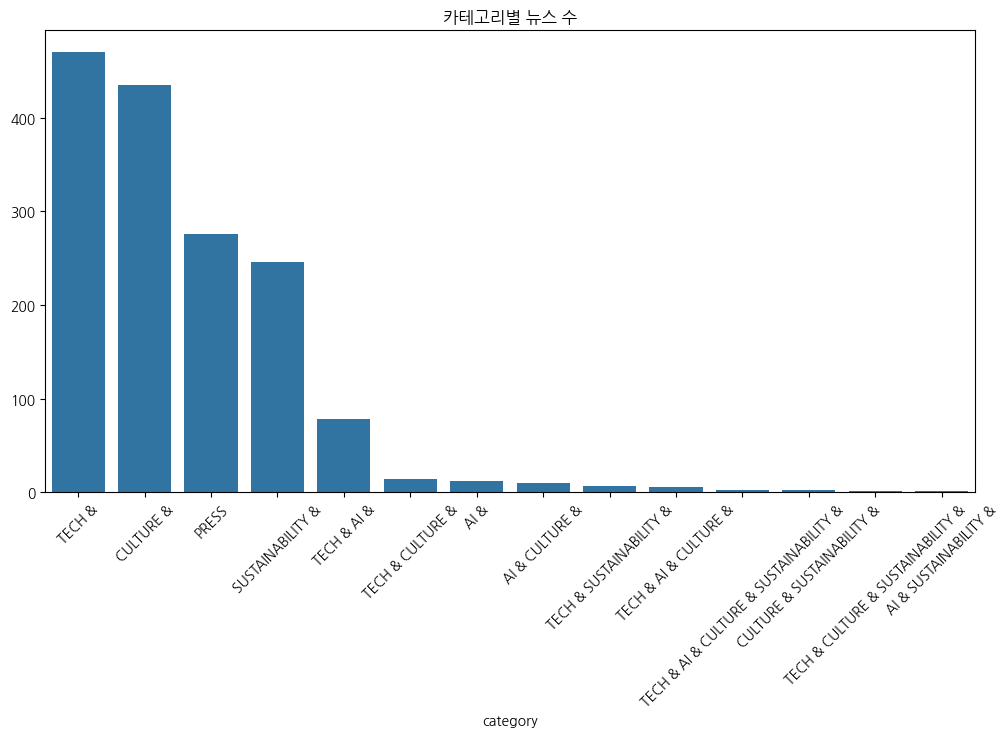

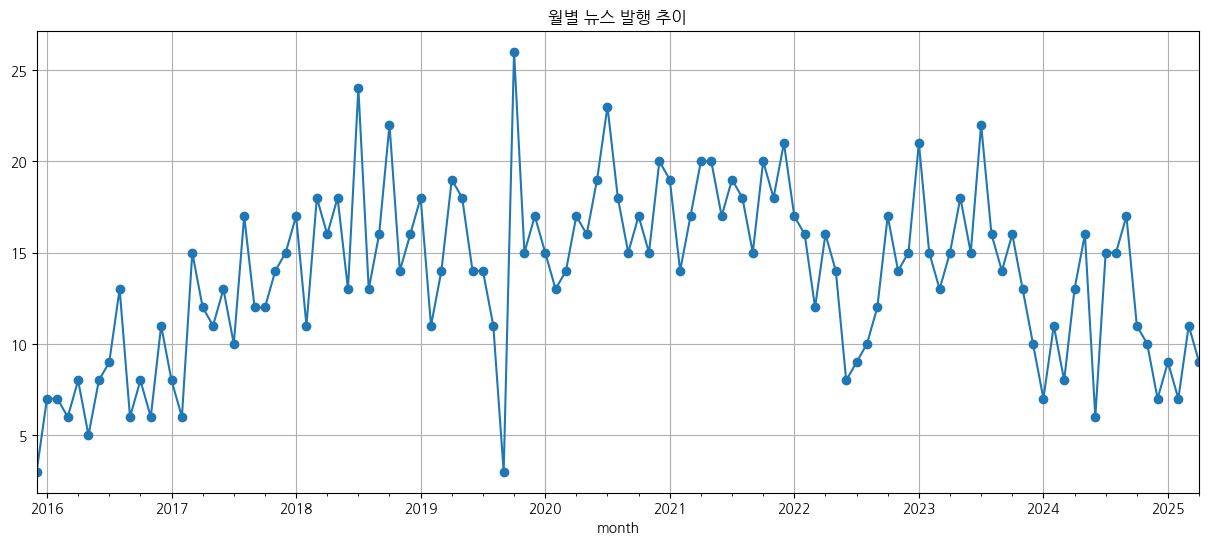

In [2]:
# 카테고리별 뉴스 수 분석
category_counts = df['category'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('카테고리별 뉴스 수')
plt.xticks(rotation=45)
plt.show()

# 월별 뉴스 발행 추이
df['month'] = df['date'].dt.to_period('M')
monthly_counts = df.groupby('month').size()
plt.figure(figsize=(15, 6))
monthly_counts.plot(kind='line', marker='o')
plt.title('월별 뉴스 발행 추이')
plt.grid(True)
plt.show()

## 2. 텍스트 분석 준비
1. 도메인 키워드를 카테고리별로 구조화하여 정의
- 리더십 관련 키워드
- 반도체 기술/제품 관련 키워드
- 기업명
- 기술 관련 키워드
2. 영어-한글 혼합 형태 보존
- HBM, DDR5 등의 기술 명칭
- SK하이닉스와 같은 기업명
3. 특수문자와 숫자 처리 개선
- 1αnm, HBM3E 등의 기술 명칭 보존
- 특수문자 제거 시 도메인 키워드는 보존
4. 형태소 분석 시 의미 있는 단어 추출 기준 개선
- 도메인 키워드는 무조건 보존
- 영어-한글 혼합 형태 보존
- 일반 명사, 형용사, 동사 중 의미 있는 것만 추출
5. 2-gram 분석 추가
- 연속된 단어들의 패턴을 파악하여 의미 있는 문구 추출

In [3]:
# 날짜 필터링 (2016-2024년)
df = df[(df['date'].dt.year >= 2016) & (df['date'].dt.year <= 2024)]

# 도메인 키워드 정의
domain_keywords = {
    '탐색적 리더십(Exploration)': [
        '탐색', 'Exploration', 'CEO', '사장', '대표이사', '회장', '경영진', '임원', '수석', '총괄', 
        '책임자', '이사', '혁신', '변화', '연구', '투자', '실패 수용', '장기적 이익', '대담한 전략', 
        '혁신적 사고', '조직 변화', '비전', '권한 위임', '적응력', '유연성', '위기 관리', '변혁적 리더십', 
        '개발', '진정성 리더십', '지속가능성'
    ],
    '활용적 리더십(Exploitation)': [
        '활용', 'Exploitation', 'CEO', '사장', '대표이사', '회장', '경영진', '임원', '수석', '총괄', 
        '책임자', '이사', '성과', '성장', '경영', '전략', '위험 회피', '단기적 이익', '효율적 운영', 
        '지속적 개선', '인재 개발', '의사결정', '동기 부여', '팀워크', '소통', '성과 관리', '문제 해결', 
        '조직 문화', '고객 중심', '관계 구축', '협업', '영향력', '윤리적 리더십', '섬김의 리더십'
    ],
    'semiconductor': [
        'HBM', 'HBM1', 'HBM2', 'HBM2E', 'HBM3', 'HBM3E', 'HBM4',
        'DDR4', 'DDR5', 'DDR6', 'LPDDR6',
        'DRAM', 'D램', 'NAND', '낸드', '플래시',
        'TSV', 'Through Silicon Via',
        '1αnm', '1-alpha', '1γnm', '1-gamma', '1δnm', '1-delta',
        'VG DRAM', 'Vertical Gate', '3D DRAM',
        '파운드리', '팹리스', '패키징', '웨이퍼'
    ],
    'technology': [
        'AI', '인공지능', '빅데이터', '클라우드', '5G', '6G', 'IoT',
        '자율주행', '메타버스', '양자컴퓨팅', '로봇', '자동화',
        '스마트팩토리', '디지털트랜스포메이션'
    ]
}

# 모든 도메인 키워드를 하나의 리스트로 통합
all_domain_keywords = [keyword for keywords in domain_keywords.values() for keyword in keywords]

# 영어-한글 혼합 패턴 정의
mixed_pattern = re.compile(r'[A-Za-z]+[가-힣]+|[가-힣]+[A-Za-z]+')

# 제거할 품사 태그 정의
remove_pos = {'JKS', 'JKO', 'JKB', 'JX', 'JC', 'EP', 'EF', 'EC', 'ETN', 'ETM'}

# Mecab 초기화
mecab = Mecab()

def preprocess_text(text):
    if pd.isna(text):
        return ''
    
    # 도메인 키워드 보존
    for keyword in all_domain_keywords:
        text = text.replace(keyword, f' {keyword} ')
    
    # 영어-한글 혼합 형태 보존
    mixed_words = set(mixed_pattern.findall(text))
    
    # 특수문자 제거 (단, 도메인 키워드와 영어-한글 혼합 형태는 보존)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 형태소 분석
    pos = mecab.pos(text)
    
    # 의미 있는 단어 추출
    words = []
    for word, pos_tag in pos:
        # 영어-한글 혼합 형태는 보존
        if word in mixed_words:
            words.append(word)
            continue
            
        # 도메인 키워드는 보존
        if word in all_domain_keywords:
            words.append(word)
            continue
            
        # 일반 명사, 형용사, 동사 추출 (조사, 어미 등 제외)
        if pos_tag in ['NNG', 'NNP', 'VA', 'VV'] and pos_tag not in remove_pos:
            # 한 글자 한자어 제외
            if not (len(word) == 1 and '\u4e00' <= word <= '\u9fff'):
                words.append(word)
    
    return ' '.join(words)

# 텍스트 전처리 적용
df['processed_content'] = df['content'].apply(preprocess_text)

# 샘플 출력
print("전처리된 텍스트 샘플:")
print(df['processed_content'].iloc[0][:200])

# 도메인 키워드 등장 빈도 확인
keyword_freq = {}
for keyword in all_domain_keywords:
    freq = sum(1 for text in df['processed_content'] if keyword in text)
    if freq > 0:
        keyword_freq[keyword] = freq

print("\n도메인 키워드 등장 빈도:")
for keyword, freq in sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True):
    print(f"{keyword}: {freq}회")

# 2-gram 분석
from nltk import bigrams
import nltk
nltk.download('punkt')

# 2-gram 추출
bigram_list = []
for text in df['processed_content']:
    words = text.split()
    bigram_list.extend(list(bigrams(words)))

# 2-gram 빈도수 계산
bigram_freq = Counter(bigram_list)

print("\n자주 등장하는 2-gram:")
for (word1, word2), count in bigram_freq.most_common(20):
    print(f"{word1} {word2}: {count}")

전처리된 텍스트 샘플:
올해 하이닉스 글로벌 AI 메모리 프로 바이더 AI 목표 기술 혁신 AI 메모리 시장 자리 램 DRAM 낸드 플래시 NAND 낸드 아우르 풀 스택 AI 메모리 프로 바이더 AI 나아가 준비 가운데 회사 임직원 소통 강화 구성원 가족 행복 챙기 한편 지속 가능 환경 조성 많 노력 뉴스룸 숨 가쁘 해 정리 인공지능 AI 열풍 올해 텍스트 기반 멀티 모달 나아가

도메인 키워드 등장 빈도:
개발: 908회
활용: 748회
성장: 651회
변화: 562회
연구: 496회
혁신: 443회
성과: 430회
AI: 430회
경영: 417회
사장: 352회
문제 해결: 340회
협업: 337회
투자: 336회
소통: 321회
전략: 308회
낸드: 299회
인공지능: 298회
웨이퍼: 255회
플래시: 244회
DRAM: 234회
HBM: 207회
NAND: 206회
비전: 199회
회장: 165회
CEO: 131회
이사: 116회
클라우드: 114회
영향력: 95회
임원: 93회
총괄: 82회
IoT: 80회
로봇: 68회
TSV: 63회
파운드리: 60회
동기 부여: 52회
조직 문화: 48회
수석: 44회
탐색: 25회
팀워크: 25회
관계 구축: 24회
책임자: 18회
자동화: 17회
고객 중심: 11회
적응력: 6회
조직 변화: 4회
권한 위임: 1회
위기 관리: 1회
지속가능성: 1회
위험 회피: 1회
성과 관리: 1회


[nltk_data] Downloading package punkt to /home/arkwith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



자주 등장하는 2-gram:
협 력사: 884
사회 가치: 872
낸드 플래시: 797
메모리 반도체: 788
부 사장: 733
문제 해결: 657
데이터 센터: 651
기술 개발: 617
반도체 산업: 552
하이닉스 구성원: 514
가치 창출: 470
제품 개발: 412
플랫 폼: 381
있 하이닉스: 376
지속 가능: 368
반도체 시장: 355
반도체 기술: 350
역할 하: 347
미래 기술: 342
지역 사회: 335


## 3. 리더십 키워드 분석
1. 도메인 키워드를 카테고리별로 구분하여 시각화
 - 리더십 관련 키워드
 - 반도체 기술/제품 관련 키워드
 - 기업명
기술 관련 키워드
2. 연도별 키워드 추이 분석 추가
 - 각 카테고리별 키워드의 연도별 등장 빈도 추이 시각화
 - 카테고리별로 구분하여 시각화
3. 2-gram 분석 결과 시각화 추가
 - 전체 기간 동안의 주요 2-gram 시각화
 - 연도별 주요 2-gram 시각화
4. 키워드 간 상관관계 분석 추가
 - 키워드 간 동시 등장 빈도 분석
 - 상관관계 히트맵 시각화

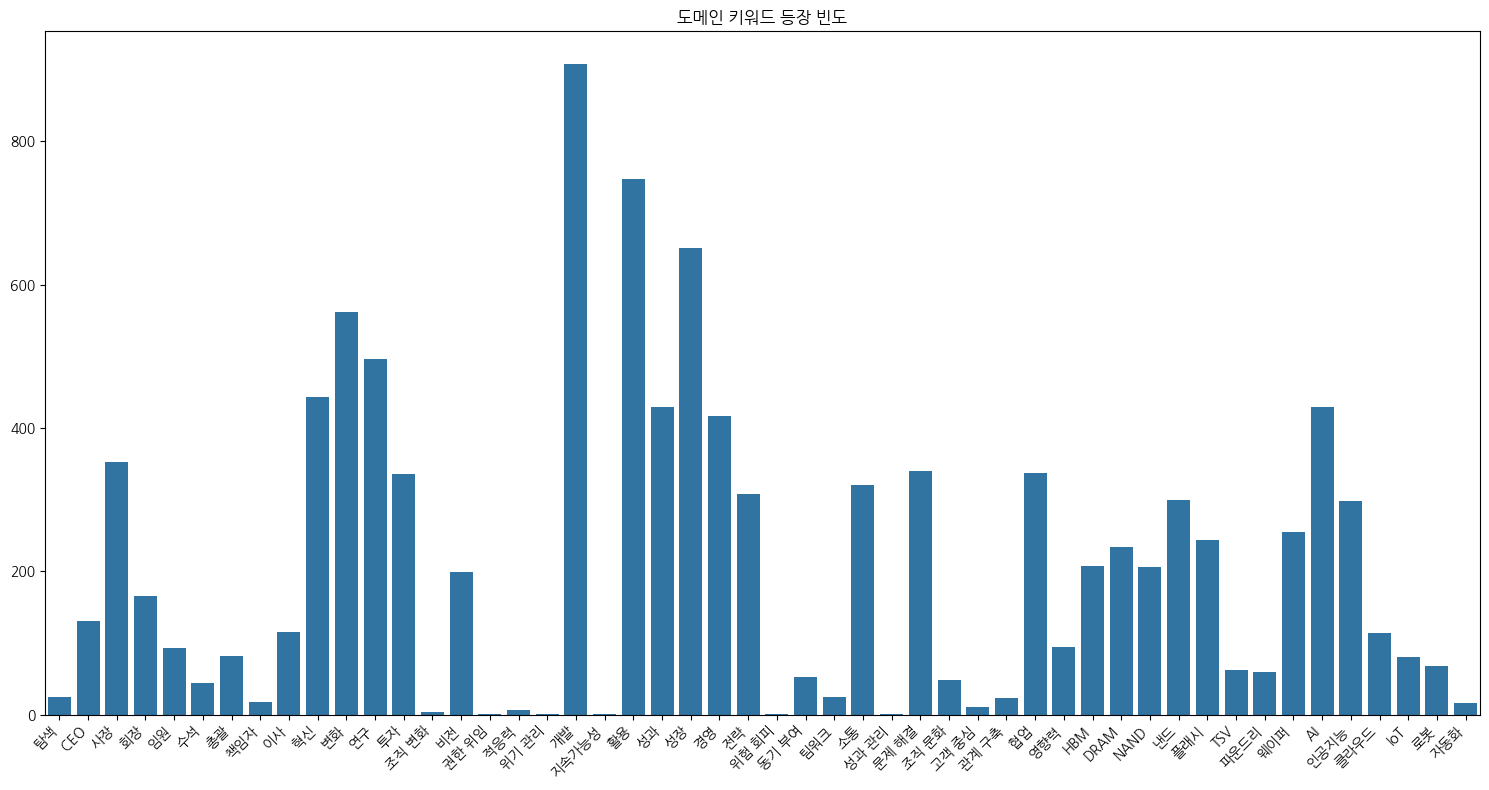

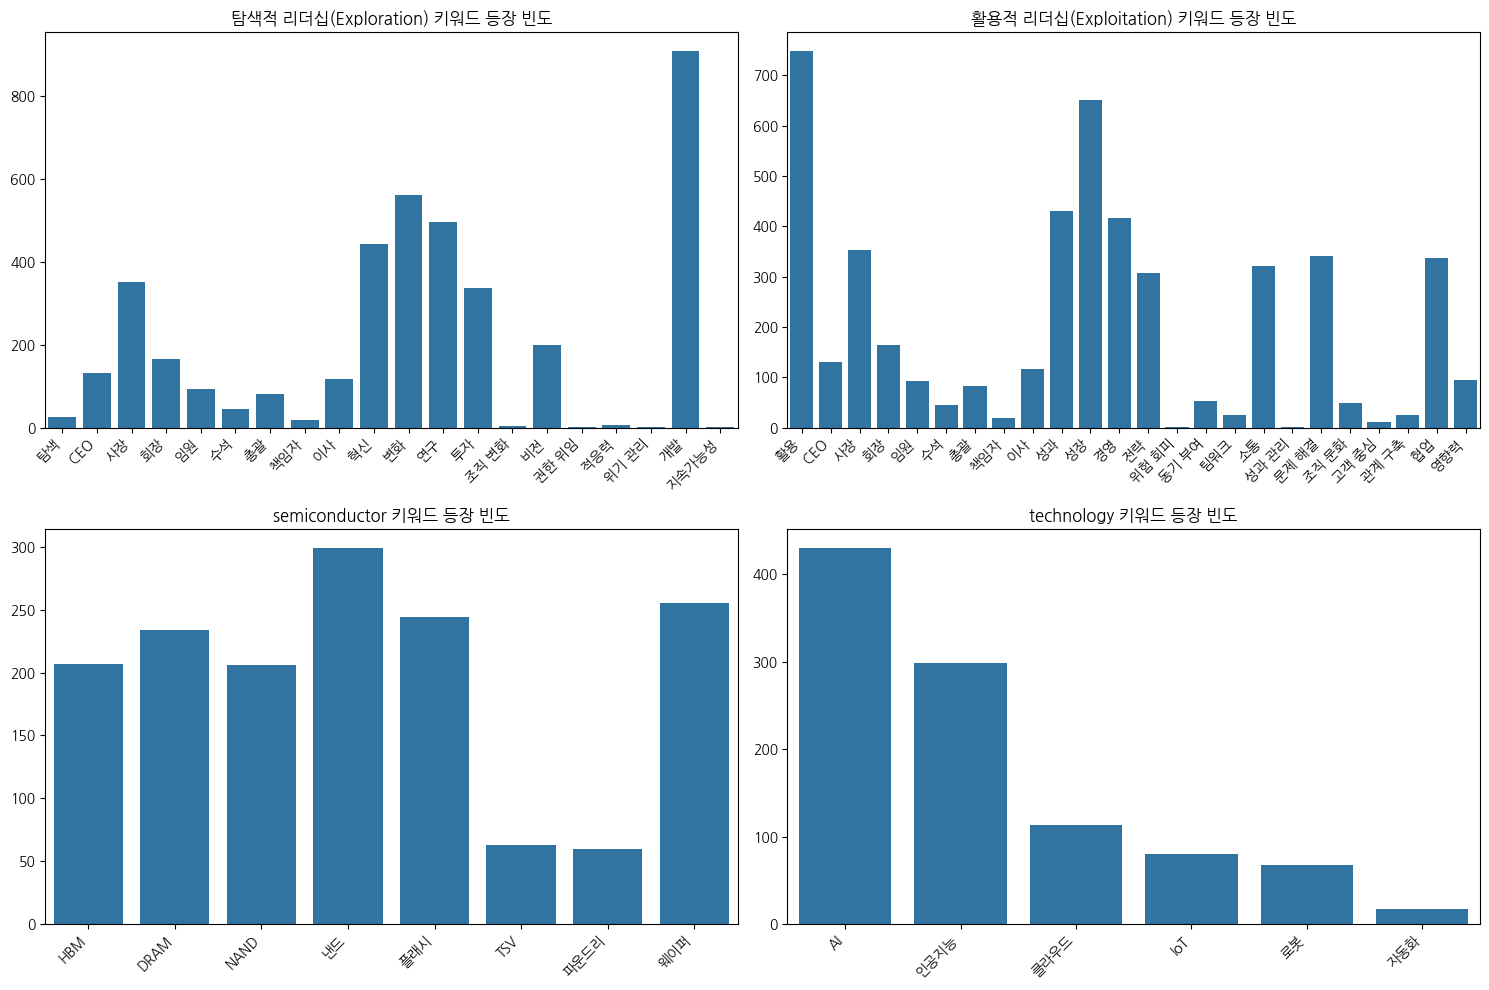

/tmp/ipykernel_11089/2183452348.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_count = df.groupby('year').apply(lambda x: sum(1 for content in x['processed_content'] if keyword in content))
/tmp/ipykernel_11089/2183452348.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_count = df.groupby('year').apply(lambda x: sum(1 for content in x['processed_content'] if keyword in content))
/tmp

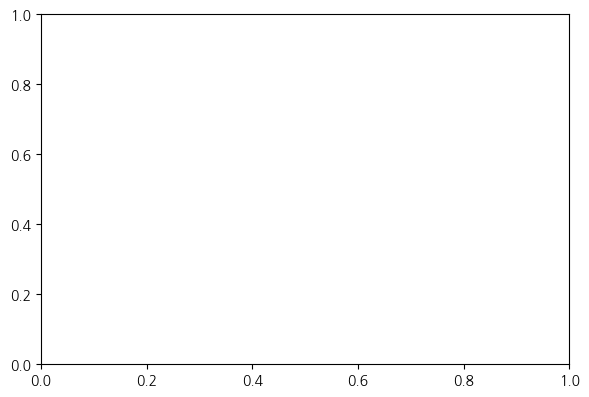

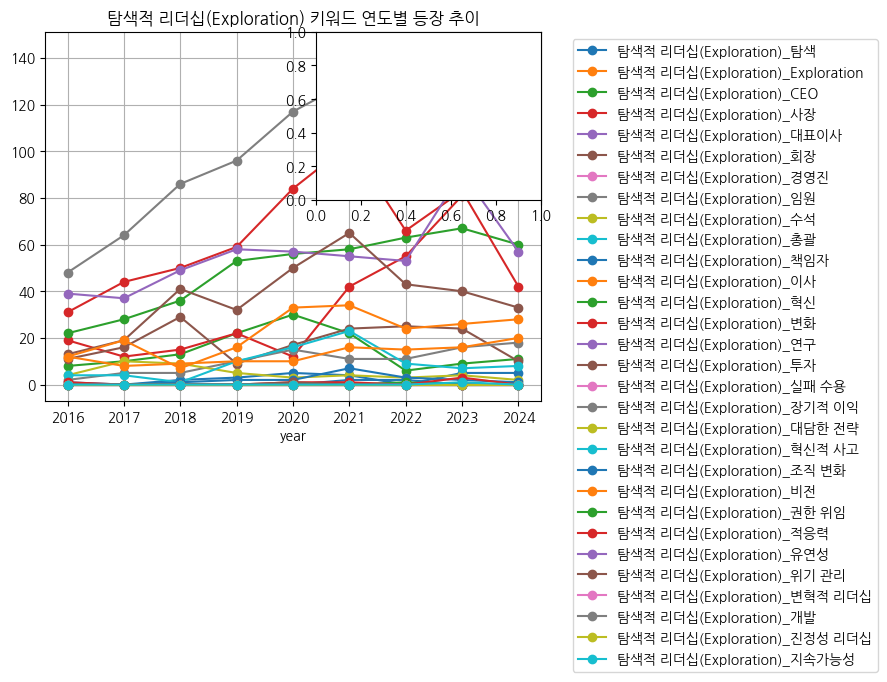

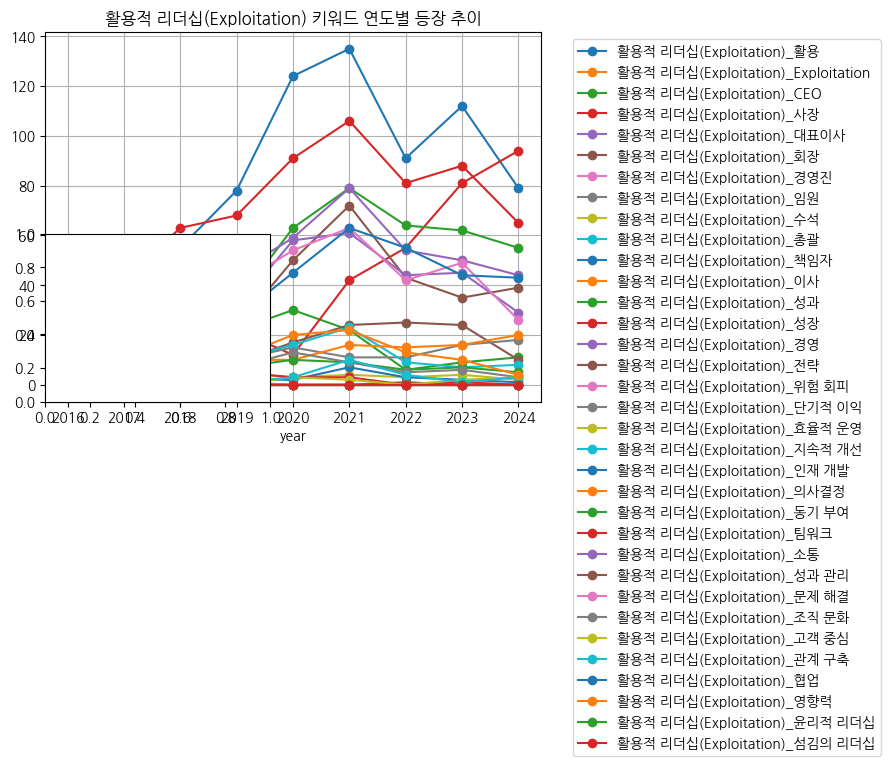

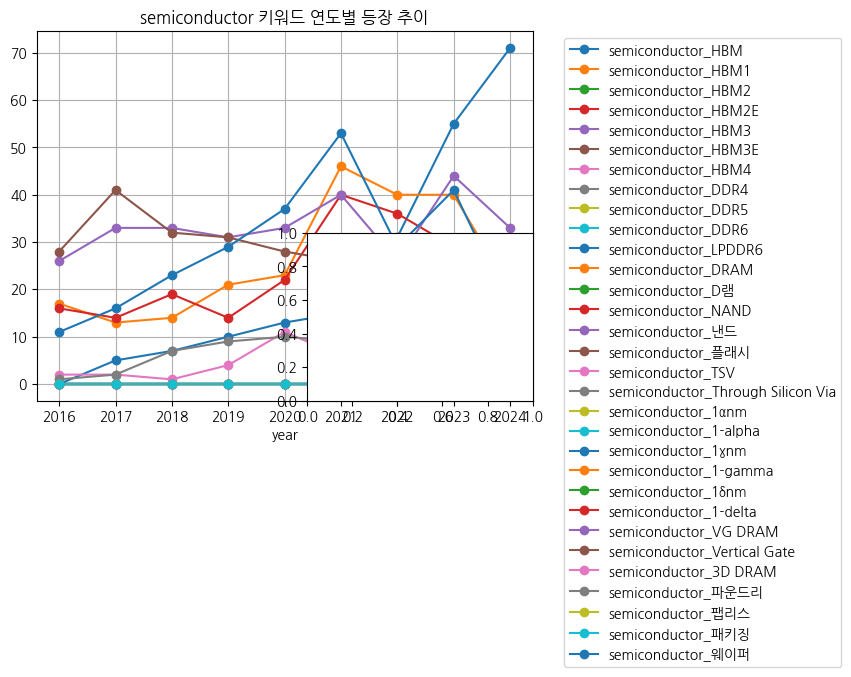

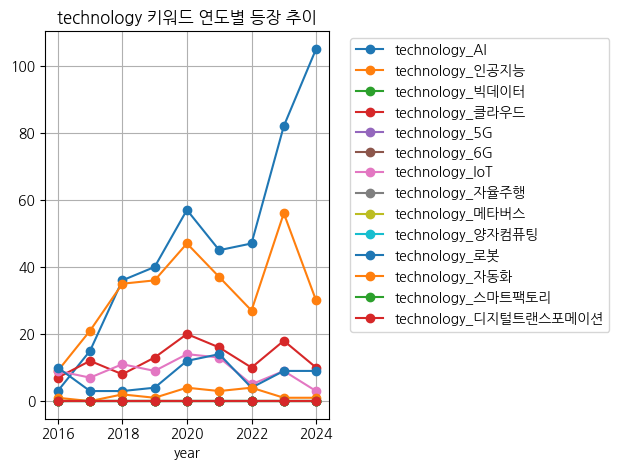

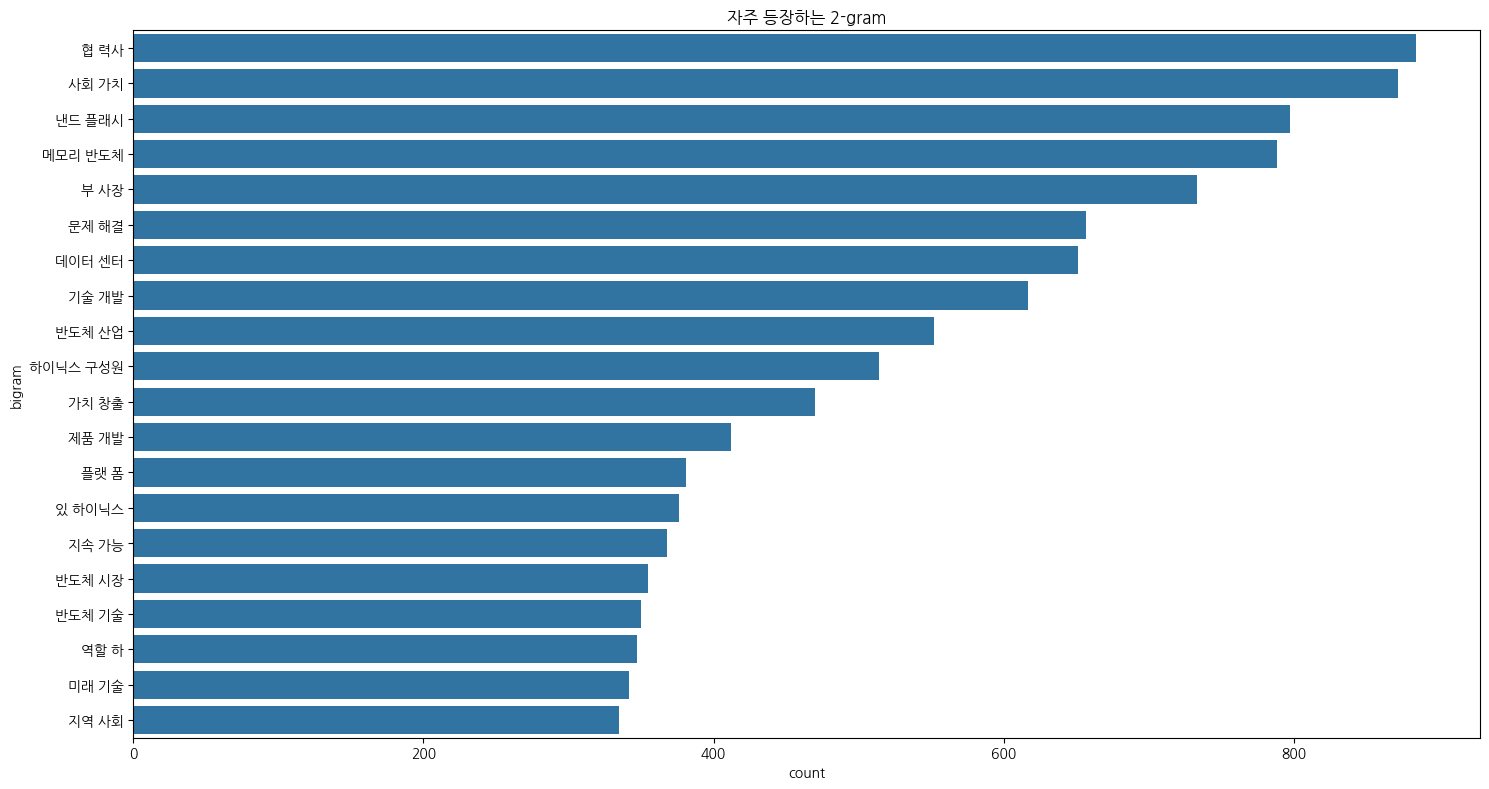

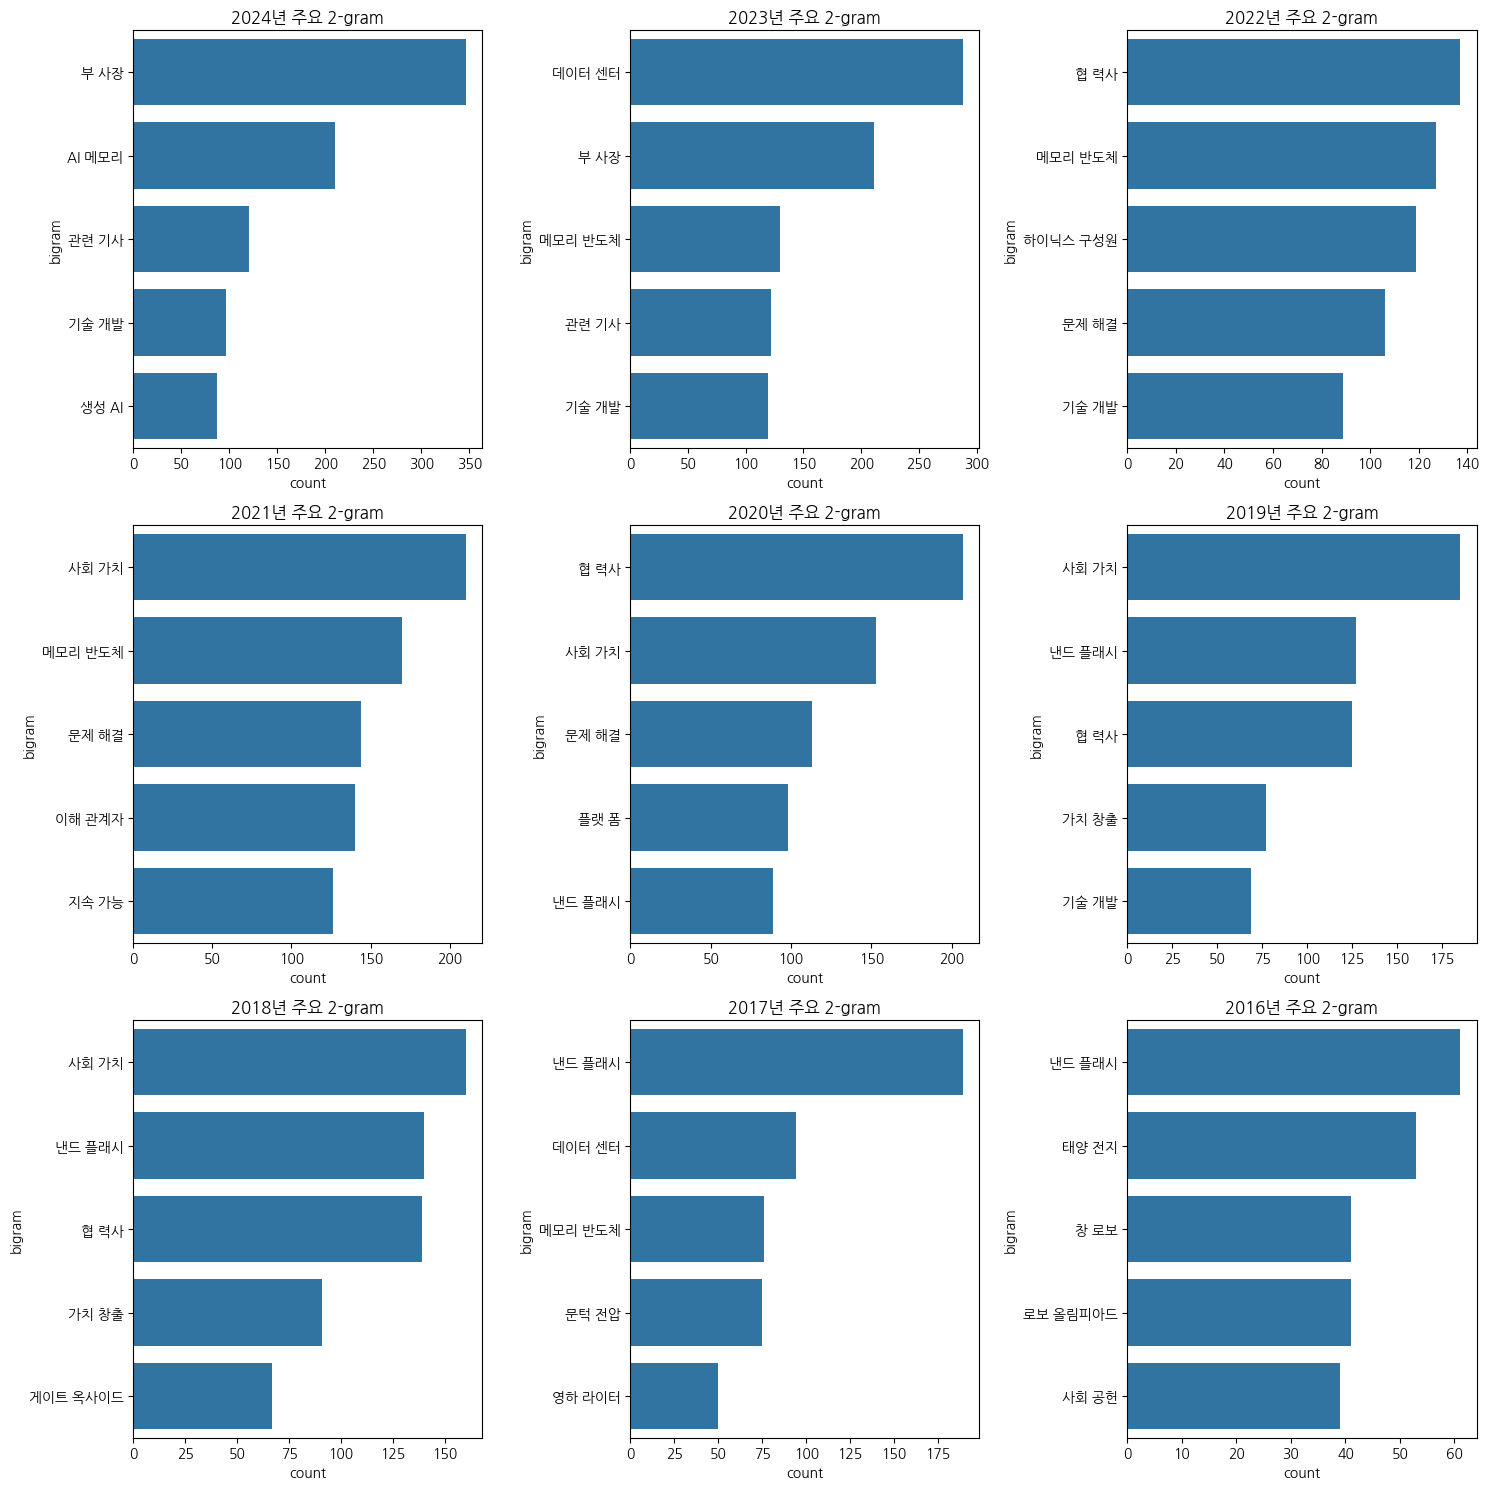

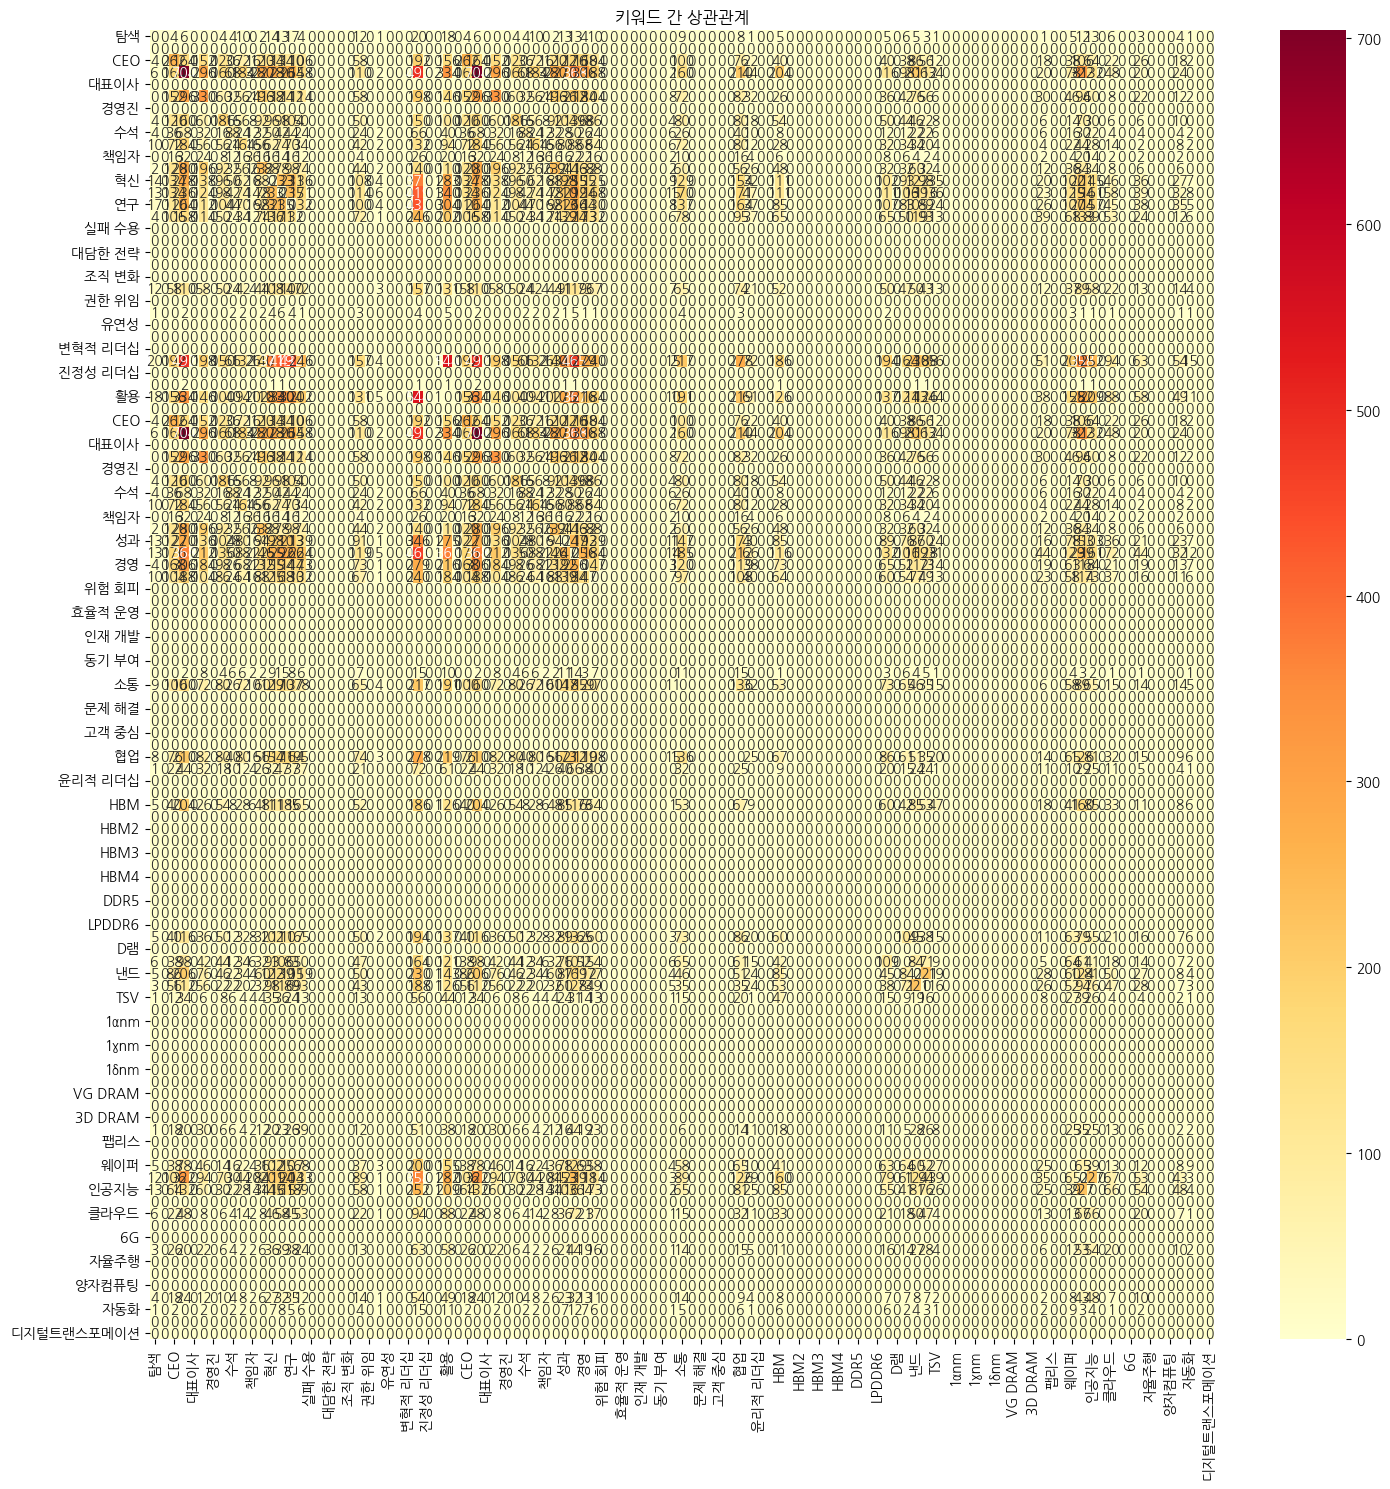

In [4]:
# 날짜 데이터에서 연도 추출
df['year'] = pd.to_datetime(df['date']).dt.year

# 키워드별 등장 빈도 분석
keyword_counts = {}
for category, keywords in domain_keywords.items():
    for keyword in keywords:
        count = sum(1 for content in df['processed_content'] if keyword in content)
        if count > 0:
            keyword_counts[keyword] = count

# 카테고리별 키워드 등장 빈도 시각화
plt.figure(figsize=(15, 8))
sns.barplot(x=list(keyword_counts.keys()), y=list(keyword_counts.values()))
plt.title('도메인 키워드 등장 빈도')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 카테고리별 키워드 등장 빈도 시각화 (카테고리별로 구분)
plt.figure(figsize=(15, 10))
for i, (category, keywords) in enumerate(domain_keywords.items(), 1):
    plt.subplot(2, 2, i)
    category_counts = {k: keyword_counts.get(k, 0) for k in keywords if k in keyword_counts}
    if category_counts:
        sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
        plt.title(f'{category} 키워드 등장 빈도')
        plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 연도별 키워드 추이 분석
yearly_keywords = pd.DataFrame()
for category, keywords in domain_keywords.items():
    for keyword in keywords:
        # yearly_count = df.groupby('year').apply(lambda x: sum(1 for content in x['processed_content'] if keyword in content))
        yearly_count = (df.groupby('year')['processed_content']
                       .agg(lambda x: sum(1 for content in x if keyword in content)))
        yearly_keywords[f'{category}_{keyword}'] = yearly_count

# 연도별 키워드 등장 추이 시각화 (카테고리별로 구분)
plt.figure(figsize=(15, 10))
for i, (category, keywords) in enumerate(domain_keywords.items(), 1):
    plt.subplot(2, 2, i)
    category_columns = [col for col in yearly_keywords.columns if col.startswith(f'{category}_')]
    if category_columns:
        yearly_keywords[category_columns].plot(kind='line', marker='o')
        plt.title(f'{category} 키워드 연도별 등장 추이')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
plt.tight_layout()
plt.show()

# 2-gram 분석 결과 시각화
plt.figure(figsize=(15, 8))
bigram_df = pd.DataFrame(bigram_freq.most_common(20), columns=['bigram', 'count'])
bigram_df['bigram'] = bigram_df['bigram'].apply(lambda x: ' '.join(x))
sns.barplot(x='count', y='bigram', data=bigram_df)
plt.title('자주 등장하는 2-gram')
plt.tight_layout()
plt.show()

# 연도별 2-gram 분석
yearly_bigrams = {}
for year in df['year'].unique():
    year_texts = df[df['year'] == year]['processed_content']
    year_bigrams = []
    for text in year_texts:
        words = text.split()
        year_bigrams.extend(list(bigrams(words)))
    yearly_bigrams[year] = Counter(year_bigrams)

# 연도별 주요 2-gram 시각화
n_years = len(yearly_bigrams)
n_cols = 3
n_rows = (n_years + n_cols - 1) // n_cols  # 올림 나눗셈

plt.figure(figsize=(15, 5*n_rows))
for i, (year, bigrams) in enumerate(yearly_bigrams.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    top_bigrams = pd.DataFrame(bigrams.most_common(5), columns=['bigram', 'count'])
    top_bigrams['bigram'] = top_bigrams['bigram'].apply(lambda x: ' '.join(x))
    sns.barplot(x='count', y='bigram', data=top_bigrams)
    plt.title(f'{year}년 주요 2-gram')
plt.tight_layout()
plt.show()

# 키워드 간 상관관계 분석
keyword_matrix = pd.DataFrame(0, index=all_domain_keywords, columns=all_domain_keywords)
for text in df['processed_content']:
    words = set(text.split())
    for i, keyword1 in enumerate(all_domain_keywords):
        for keyword2 in all_domain_keywords[i+1:]:
            if keyword1 in words and keyword2 in words:
                keyword_matrix.loc[keyword1, keyword2] += 1
                keyword_matrix.loc[keyword2, keyword1] += 1

# 키워드 간 상관관계 히트맵
plt.figure(figsize=(15, 15))
sns.heatmap(keyword_matrix, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('키워드 간 상관관계')
plt.tight_layout()
plt.show()

## 4. 워드클라우드 생성
1. 연도별 워드클라우드 생성
 - 각 연도별로 텍스트 데이터를 추출하고 단어 빈도를 계산
 - subplot을 사용하여 연도별 워드클라우드를 나란히 표시
2. 워드클라우드 설정 개선
 - max_words 파라미터 추가하여 표시할 단어 수 제한
 - 연도별은 50개, 전체 기간은 100개의 단어로 설정
3. 레이아웃 최적화
 - 연도 수에 따라 동적으로 subplot 행 수 계산
 - figure 크기를 내용에 맞게 조정

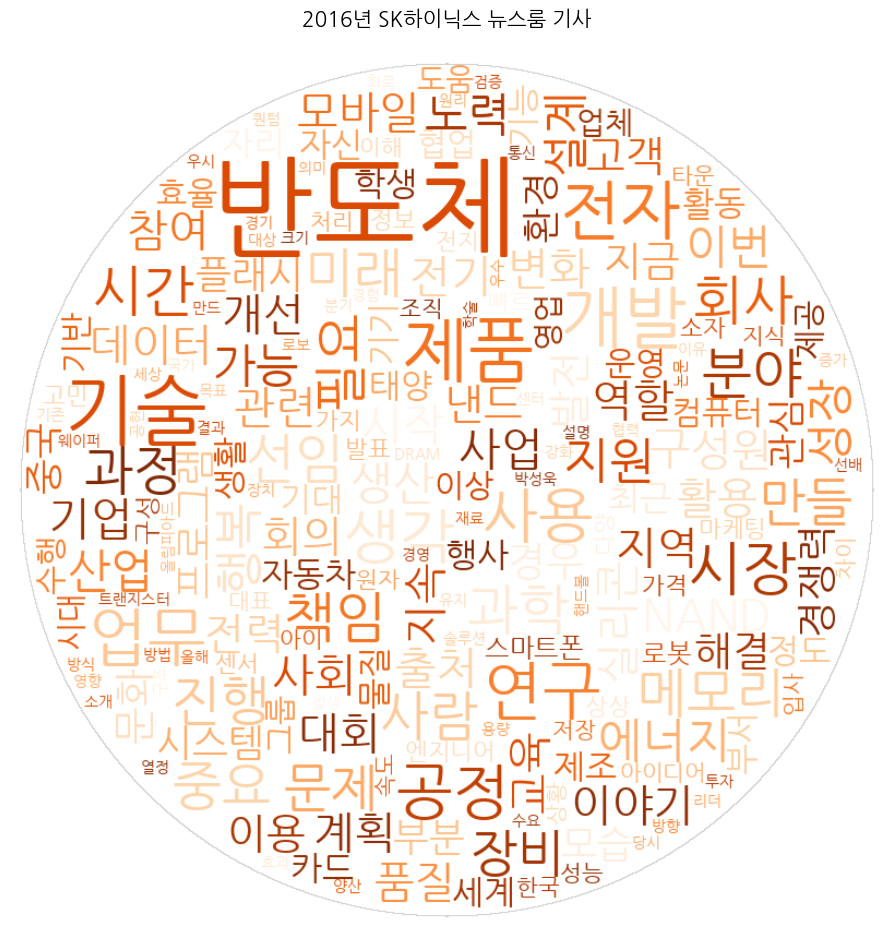

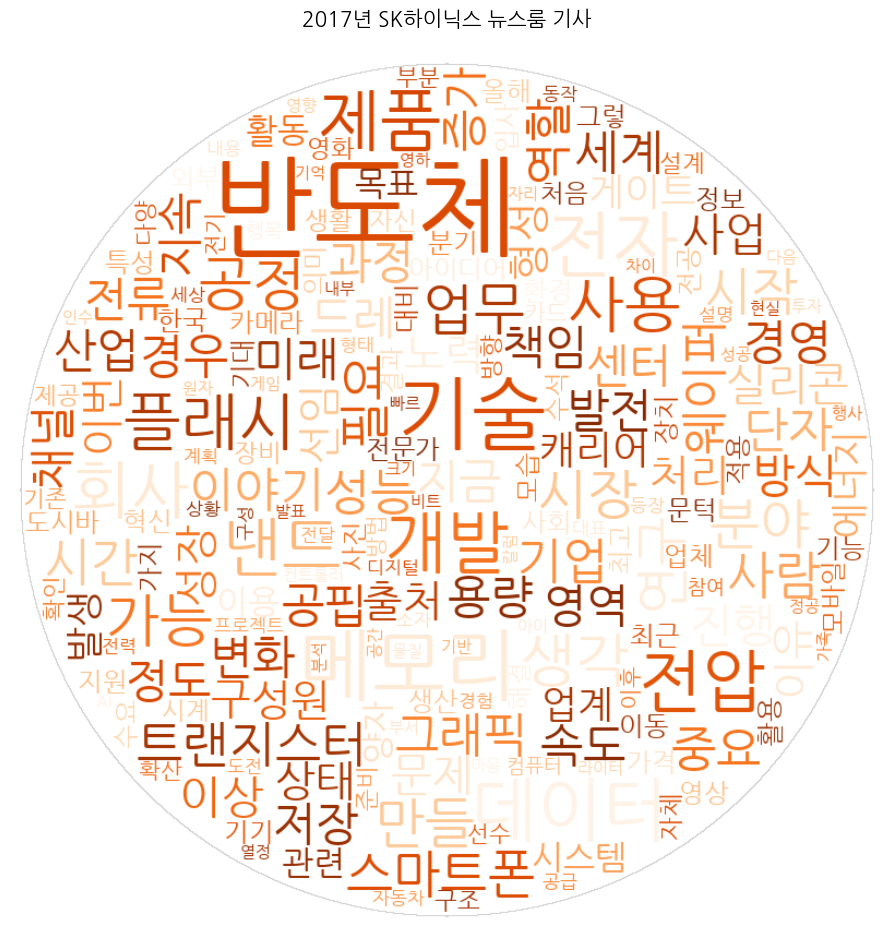

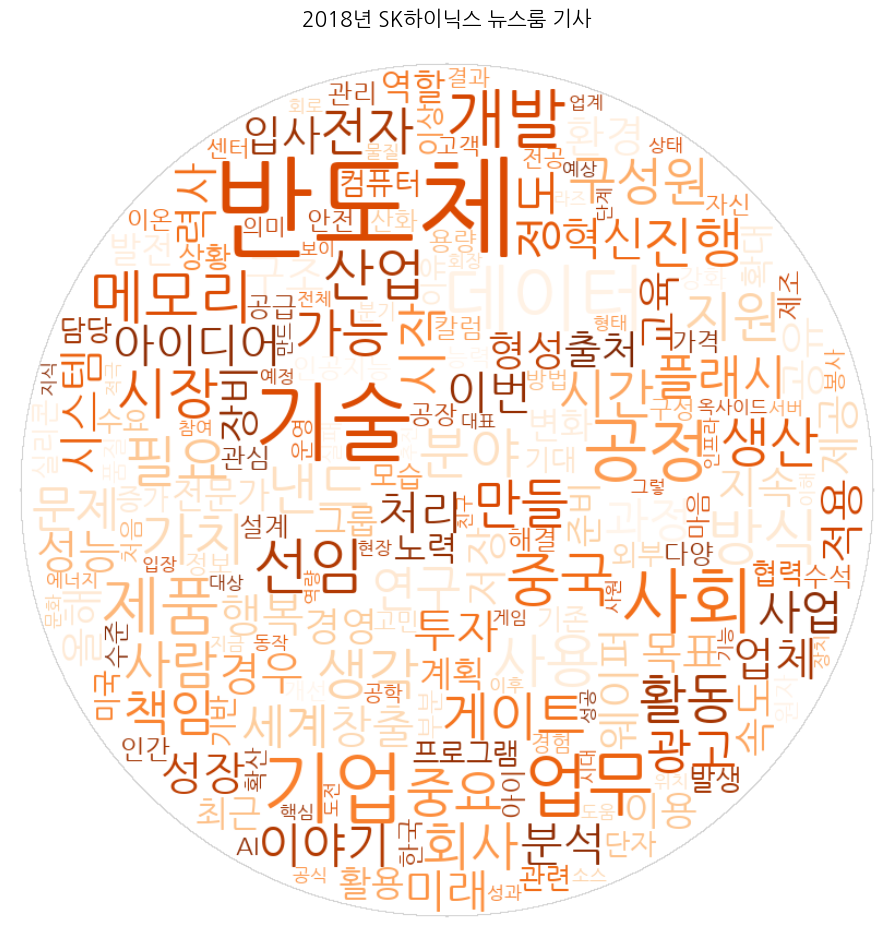

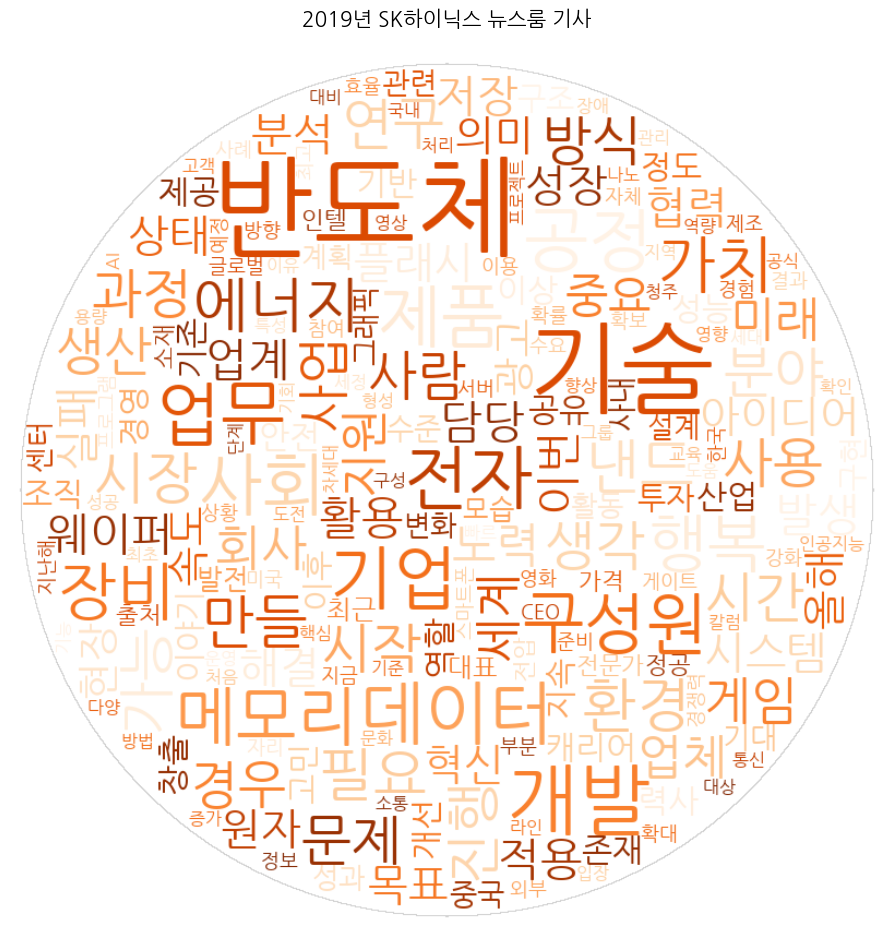

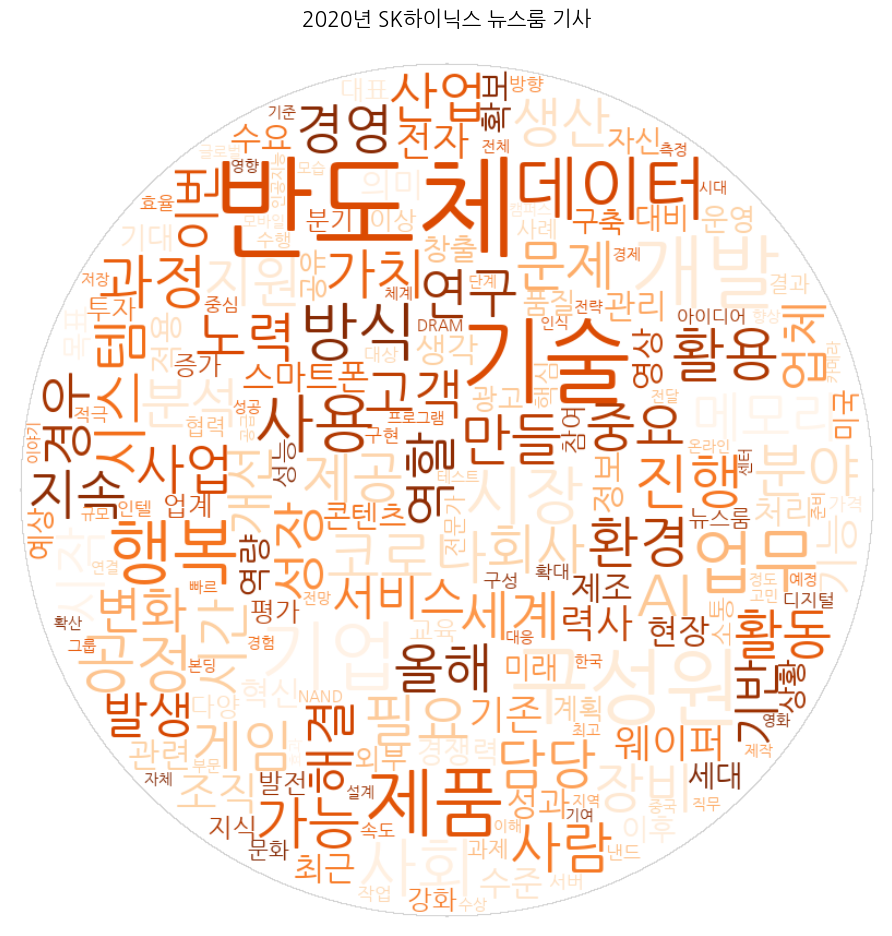

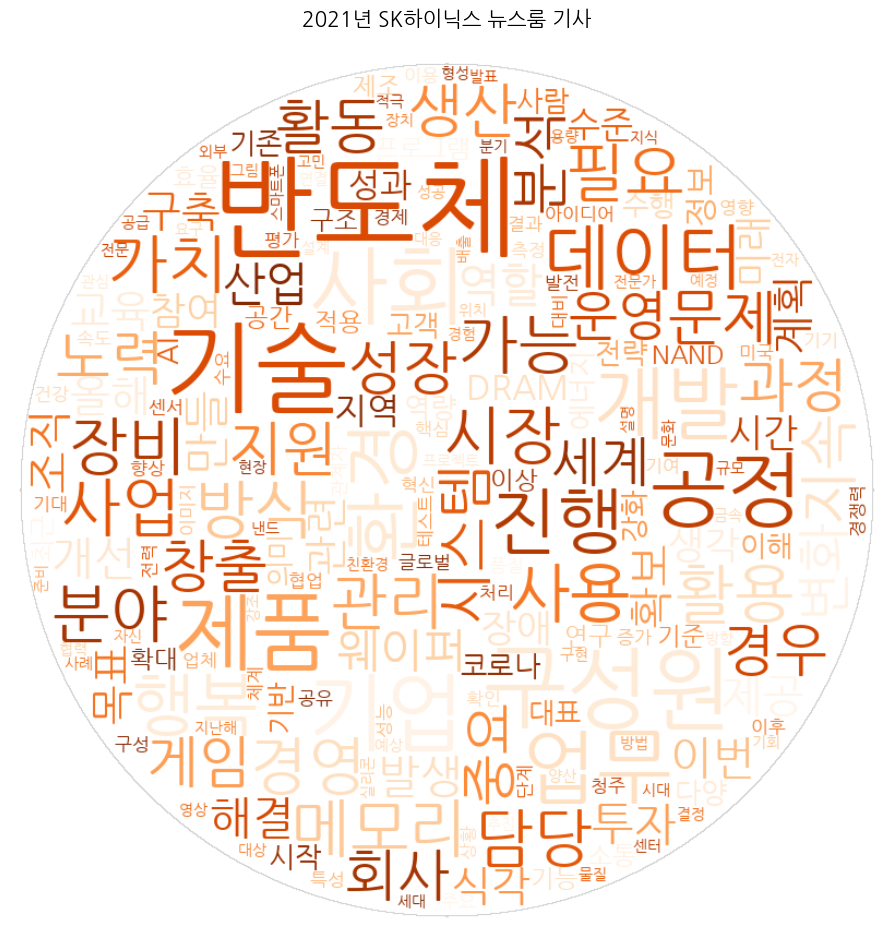

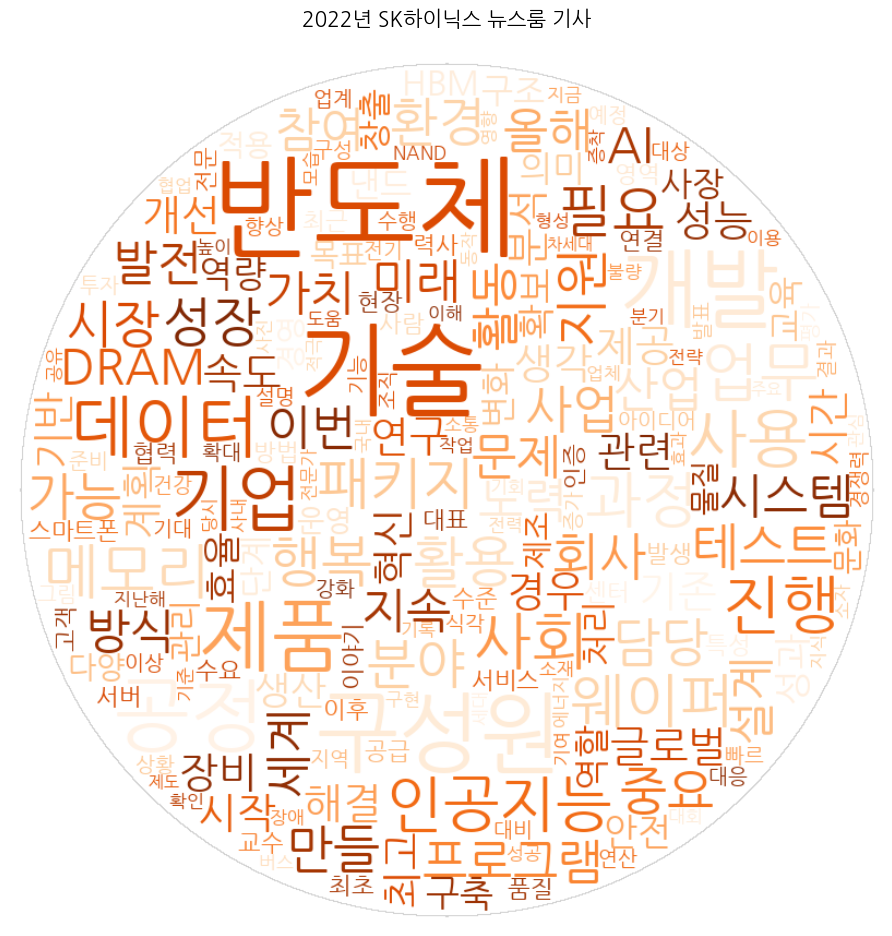

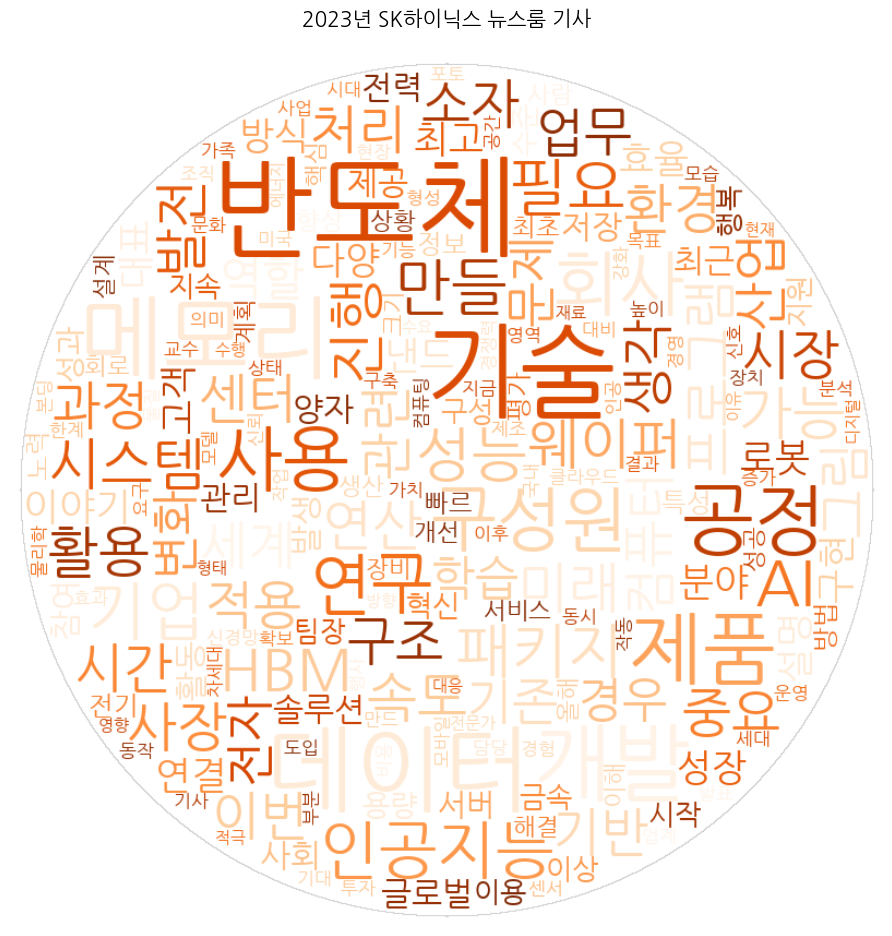

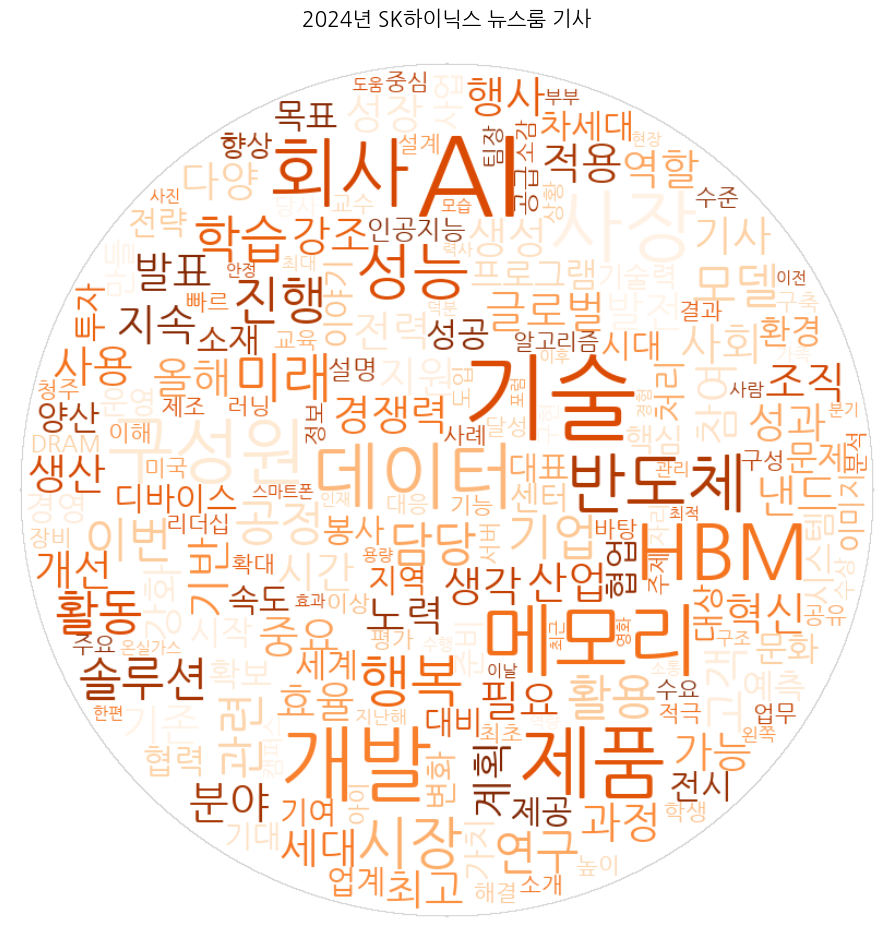

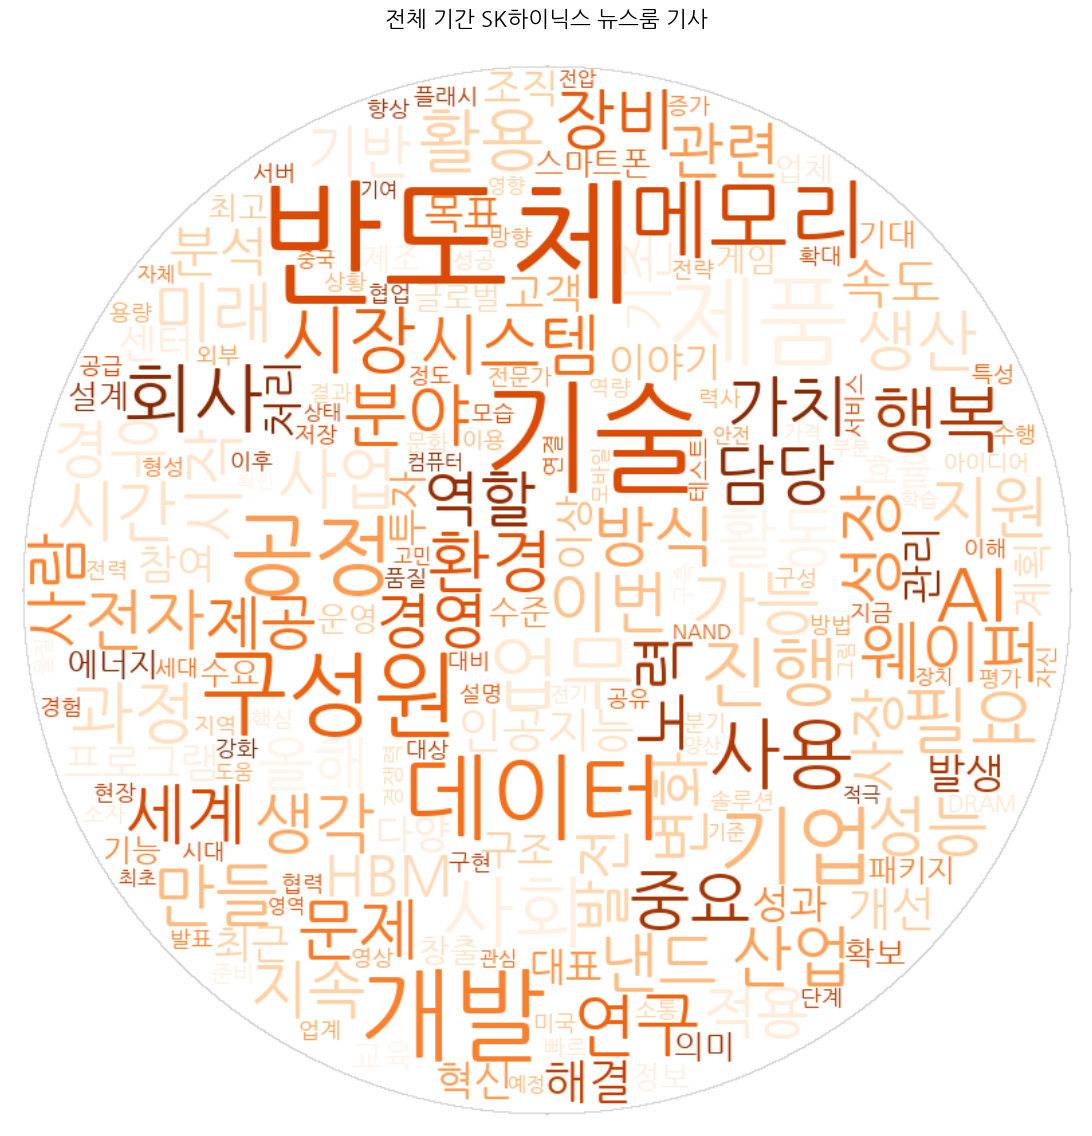

In [5]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# 제외할 단어 목록 정의
exclude_words = {
    '하이닉스', 'sk', 'sk하이닉스', 'sk하이닉스의', 'sk하이닉스는', 'sk하이닉스가',
    '있', '되', '것', '등', '들', '및', '이', '를', '을', '의', '에', '로', '로써',
    '년', '월', '일', '시', '분', '초', '주', '개', '명', '회', '차', '번'
}

# 한 글자 단어와 제외할 단어 필터링 함수
def filter_words(word_counts):
    return {word: count for word, count in word_counts.items() 
            if len(word) > 1 and word not in exclude_words}

# 정확한 원형 마스크 생성 함수
def create_inverse_circle_mask(size=800):
    x, y = np.ogrid[:size, :size]
    center = size // 2
    radius = size // 2 - 10
    circle_mask = (x - center)**2 + (y - center)**2 <= radius**2
    inverse_mask = np.where(circle_mask, 0, 255).astype(np.uint8)  # 🔁 반전
    return inverse_mask

# 3. 마스크 생성
mask = create_inverse_circle_mask(800)

width=800
height=400

# 연도별 워드클라우드 생성
for year in sorted(df['year'].unique()):
    # 해당 연도의 텍스트 데이터 추출
    year_texts = df[df['year'] == year]['processed_content']
    year_text = ' '.join(year_texts)
    
    # 해당 연도의 단어 빈도 계산 및 필터링
    year_word_counts = Counter(year_text.split())
    year_word_counts = filter_words(year_word_counts)
    
    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
        width=width,
        height=height,
        background_color='white',
        mask=mask,
        contour_width=1,
        contour_color='lightgray',
        min_font_size=10,
        max_font_size=100,
        colormap='Oranges',
        prefer_horizontal=0.9, # 가로 방향 선호도를 최대로 설정
        relative_scaling=0.5, # 단어 크기 차이를 줄임
        margin=2,  # 단어 간 간격을 줄임
        random_state=42
    ).generate_from_frequencies(year_word_counts)
    
    # 별도의 figure로 워드클라우드 표시
    plt.figure(figsize=(10, 10), facecolor='white')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{year}년 SK하이닉스 뉴스룸 기사', pad=20, fontsize=15)
    plt.tight_layout(pad=3)
    plt.show()

# 전체 텍스트 단어 카운트
all_text = ' '.join(df['processed_content'])
word_counts = Counter(all_text.split())
filtered_counts = filter_words(word_counts)

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    width=width,
    height=height,
    background_color='white',
    mask=mask,
    contour_width=1,
    contour_color='lightgray',
    min_font_size=10,
    max_font_size=100,
    colormap='Oranges',
    prefer_horizontal=0.95,
    relative_scaling=0.5,
    margin=2,
    random_state=42
).generate_from_frequencies(filtered_counts)

# 시각화
plt.figure(figsize=(12, 12), facecolor='white')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('전체 기간 SK하이닉스 뉴스룸 기사', pad=20, size=16)
plt.tight_layout(pad=3)
plt.show()

## 5. 연도별 토픽 분석

LDA를 사용한 연도별 토픽 모델링

In [11]:
# 5. 연도별 토픽 분석
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import re

# 도메인 키워드 정의
domain_keywords = {
    '탐색적 리더십(Exploration)': [
        '탐색', 'Exploration', 'CEO', '사장', '대표이사', '회장', '경영진', '임원', '수석', '총괄', 
        '책임자', '이사', '혁신', '변화', '연구', '투자', '실패 수용', '장기적 이익', '대담한 전략', 
        '혁신적 사고', '조직 변화', '비전', '권한 위임', '적응력', '유연성', '위기 관리', '변혁적 리더십', 
        '개발', '진정성 리더십', '지속가능성'
    ],
    '활용적 리더십(Exploitation)': [
        '활용', 'Exploitation', 'CEO', '사장', '대표이사', '회장', '경영진', '임원', '수석', '총괄', 
        '책임자', '이사', '성과', '성장', '경영', '전략', '위험 회피', '단기적 이익', '효율적 운영', 
        '지속적 개선', '인재 개발', '의사결정', '동기 부여', '팀워크', '소통', '성과 관리', '문제 해결', 
        '조직 문화', '고객 중심', '관계 구축', '협업', '영향력', '윤리적 리더십', '섬김의 리더십'
    ]
}

# 불용어 리스트 정의
stopwords = {
    '하이닉스', 'sk하이닉스', '반도체', 'sk', 'hynix', 
    '기자', '뉴스', '신문', '기사', '보도', '취재',
    '관계자', '이날', '지난', '올해', '작년', '내년'
}

# 전체 도메인 키워드 리스트 생성
all_domain_keywords = [keyword.lower() for keywords in domain_keywords.values() for keyword in keywords]

def preprocess_text_for_topic(text):
    if pd.isna(text):
        return []
    
    text = str(text).lower()  # 소문자 변환
    
    # 1. 도메인 키워드 보존
    preserved_words = []
    for keyword in all_domain_keywords:
        if keyword in text:
            text = text.replace(keyword, f" {keyword} ")
            preserved_words.append(keyword)
    
    # 2. 영어-한글 혼합 형태 보존
    mixed_pattern = re.compile(r'[가-힣]+[A-Za-z]+|[A-Za-z]+[가-힣]+')
    mixed_words = mixed_pattern.findall(text)
    for word in mixed_words:
        word = word.lower()
        if word not in preserved_words:
            text = text.replace(word, f" {word} ")
            preserved_words.append(word)
    
    # 3. 기본 전처리
    text = re.sub(r'[^가-힣A-Za-z0-9\s]', ' ', text)  # 특수문자 제거
    words = text.split()
    
    # 4. 단어 필터링 (불용어 제거 추가)
    filtered_words = []
    for word in words:
        # 불용어가 아니고
        if word.lower() not in stopwords:
            if word in preserved_words:  # 보존된 키워드는 그대로 유지
                filtered_words.append(word)
            elif len(word) > 1:  # 한 글자 단어 제외
                filtered_words.append(word)
    
    return filtered_words  # 토큰화된 리스트 반환

# 연도별 토픽 모델링 함수는 그대로 유지
def perform_topic_modeling(texts, num_topics=3):
    # 텍스트 전처리
    tokenized_texts = [preprocess_text_for_topic(text) for text in texts]
    
    # 빈 문서 제거
    tokenized_texts = [text for text in tokenized_texts if text]
    
    if not tokenized_texts:
        raise ValueError("전처리 후 텍스트가 없습니다.")
    
    # 딕셔너리 생성
    dictionary = corpora.Dictionary(tokenized_texts)
    
    # 극단적인 빈도의 단어만 필터링
    dictionary.filter_extremes(no_below=2, no_above=0.9)
    
    # 코퍼스 생성
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    if not corpus:
        raise ValueError("생성된 코퍼스가 비어있습니다.")
    
    # LDA 모델 학습
    lda_model = models.LdaModel(
        corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=20,
        alpha='auto',
        random_state=42
    )
    
    return lda_model, corpus, dictionary
   
# 연도별 데이터 분리 및 토픽 모델링
yearly_topics = {}
yearly_models = {}

for year in sorted(df['year'].unique()):
    year_texts = df[df['year'] == year]['processed_content']
    
    if len(year_texts) > 0:
        try:
            print(f"\n{year}년 토픽 모델링 결과:")
            
            # 토픽 모델링 수행
            lda_model, corpus, dictionary = perform_topic_modeling(year_texts)
            yearly_models[year] = (lda_model, corpus, dictionary)
            
            # 토픽 추출
            topics = {}
            for idx, topic in lda_model.show_topics(formatted=False, num_words=10):  # 단어 수를 10개로 증가
                topics[idx] = [(word, round(prob, 4)) for word, prob in topic]
                print(f"\n토픽 {idx+1}:")
                print(", ".join([f"{word} ({prob:.4f})" for word, prob in topics[idx]]))
            
            yearly_topics[year] = topics
            
            # pyLDAvis 시각화 생성
            vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
            pyLDAvis.save_html(vis_data, f'topic_vis_{year}.html')
            
        except Exception as e:
            print(f"{year}년 처리 중 오류 발생: {str(e)}")
            continue


2016년 토픽 모델링 결과:

토픽 1:
과학 (0.0176), 행복 (0.0129), 지원 (0.0124), 사회 (0.0109), 사업 (0.0093), 지역 (0.0088), 학생 (0.0069), 활동 (0.0064), 진행 (0.0064), 지속 (0.0064)

토픽 2:
전자 (0.0168), 사용 (0.0126), 기술 (0.0108), 에너지 (0.0083), 개발 (0.0078), 출처 (0.0066), 연구 (0.0063), 실리콘 (0.0061), 전기 (0.0061), 제품 (0.0056)

토픽 3:
업무 (0.0154), 제품 (0.0115), 기술 (0.0113), 생각 (0.0110), 책임 (0.0109), 선임 (0.0102), 개발 (0.0101), 공정 (0.0090), 회사 (0.0087), 연구 (0.0083)

2017년 토픽 모델링 결과:

토픽 1:
회사 (0.0107), 업무 (0.0096), 생각 (0.0092), 기술 (0.0091), 분야 (0.0075), 개발 (0.0070), 데이터 (0.0065), 시간 (0.0060), 책임 (0.0058), 공정 (0.0058)

토픽 2:
메모리 (0.0164), 낸드 (0.0123), 기술 (0.0116), 플래시 (0.0115), 제품 (0.0104), 데이터 (0.0097), 시장 (0.0093), 스마트폰 (0.0092), 사용 (0.0078), 그래픽 (0.0072)

토픽 3:
전압 (0.0261), 전자 (0.0251), 트랜지스터 (0.0125), 단자 (0.0121), 드레 (0.0108), 공핍 (0.0107), 전류 (0.0101), 채널 (0.0098), 영역 (0.0097), 실리콘 (0.0088)

2018년 토픽 모델링 결과:

토픽 1:
방식 (0.0149), 공정 (0.0144), 게이트 (0.0116), 사용 (0.0112), 전자 (0.0082), 기술 (0.0079), 웨이퍼 (0.0066), 형성 (0.0065), 단자 (

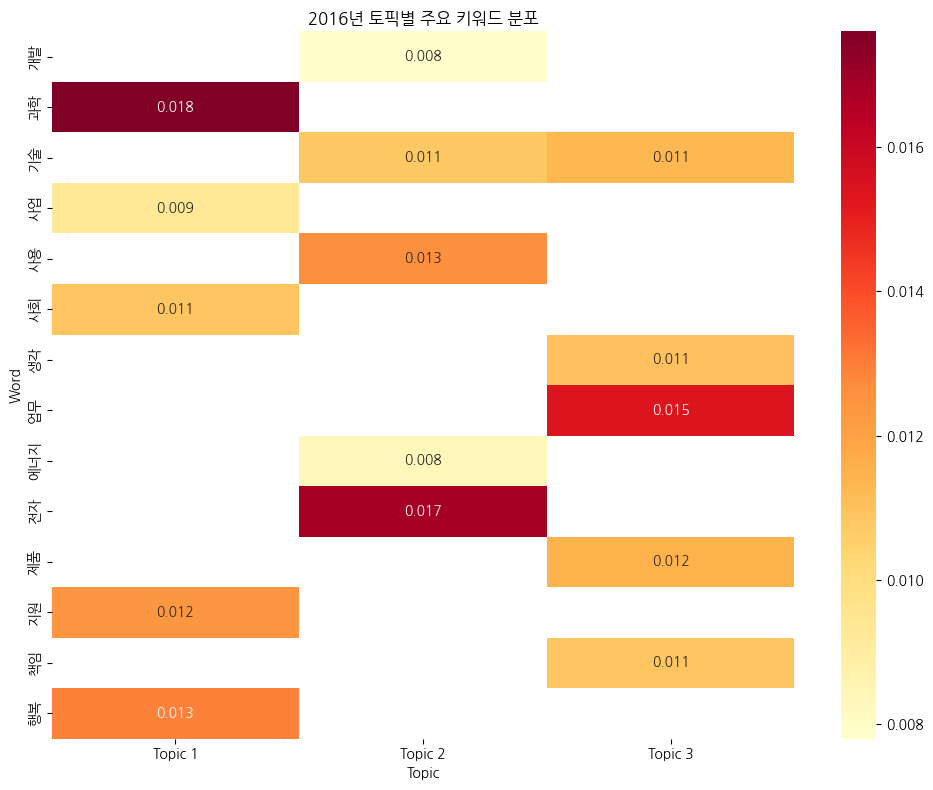

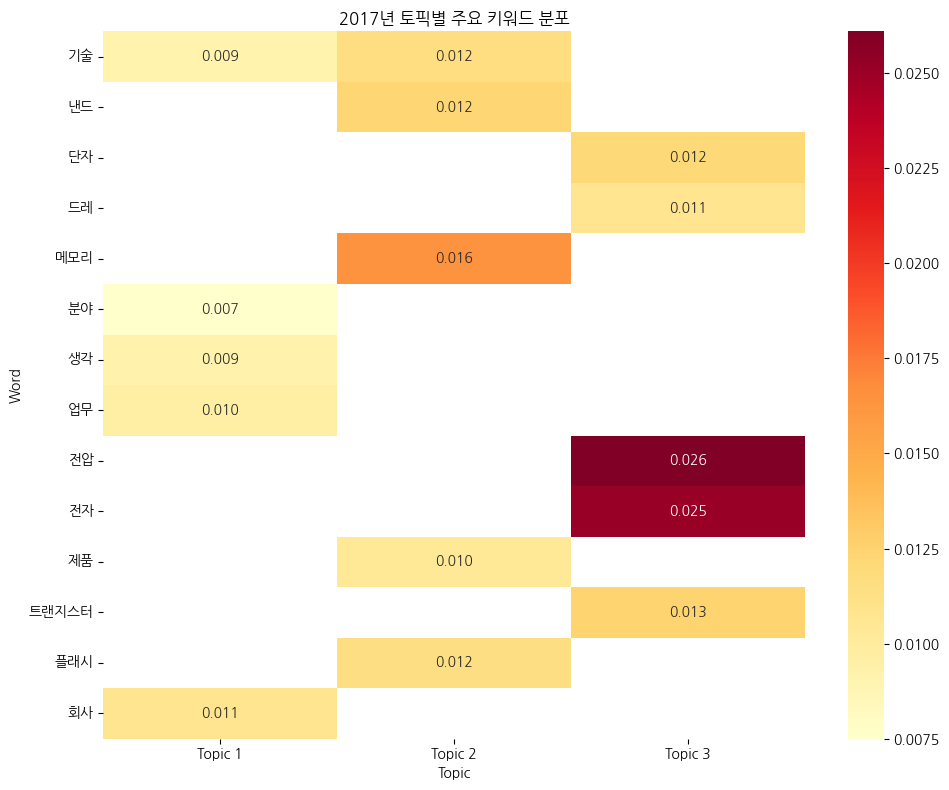

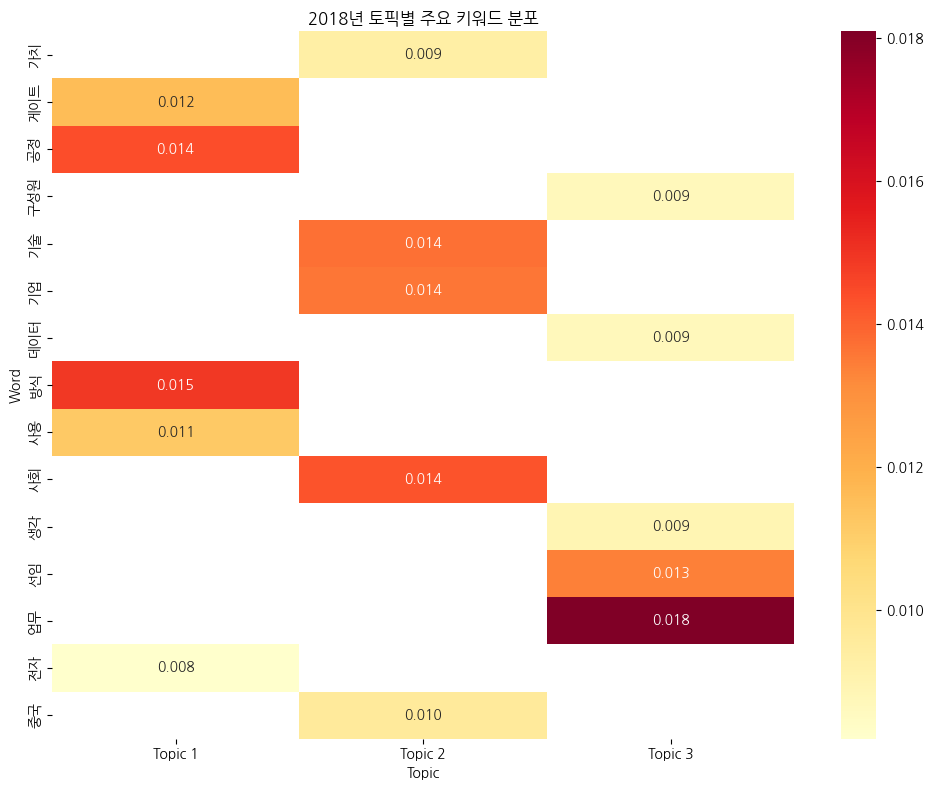

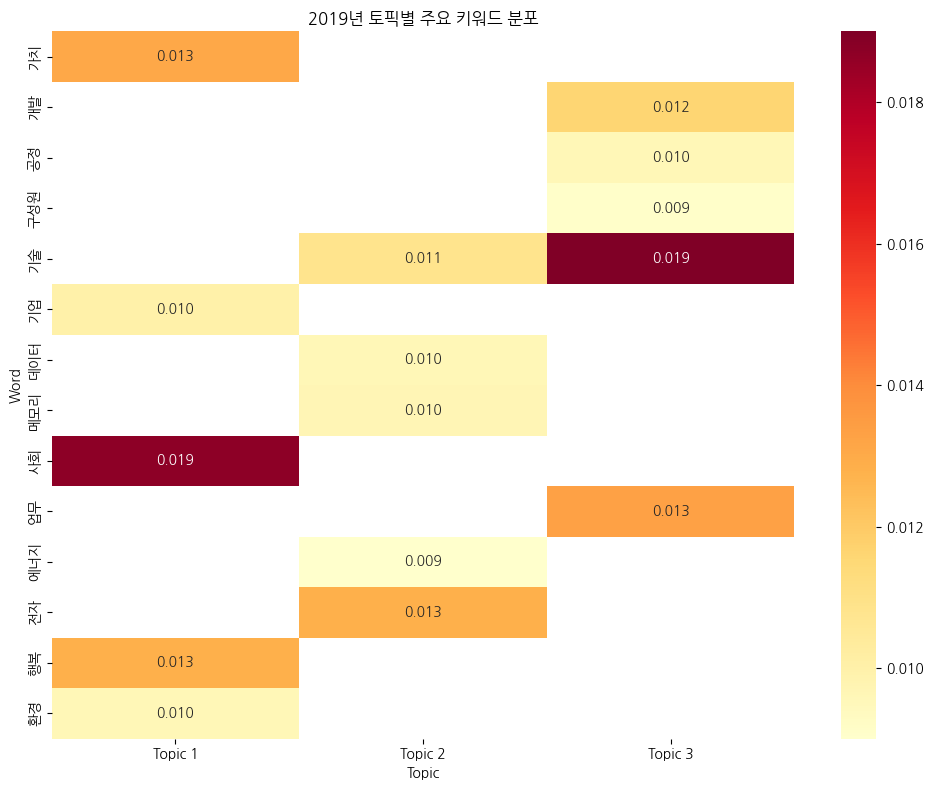

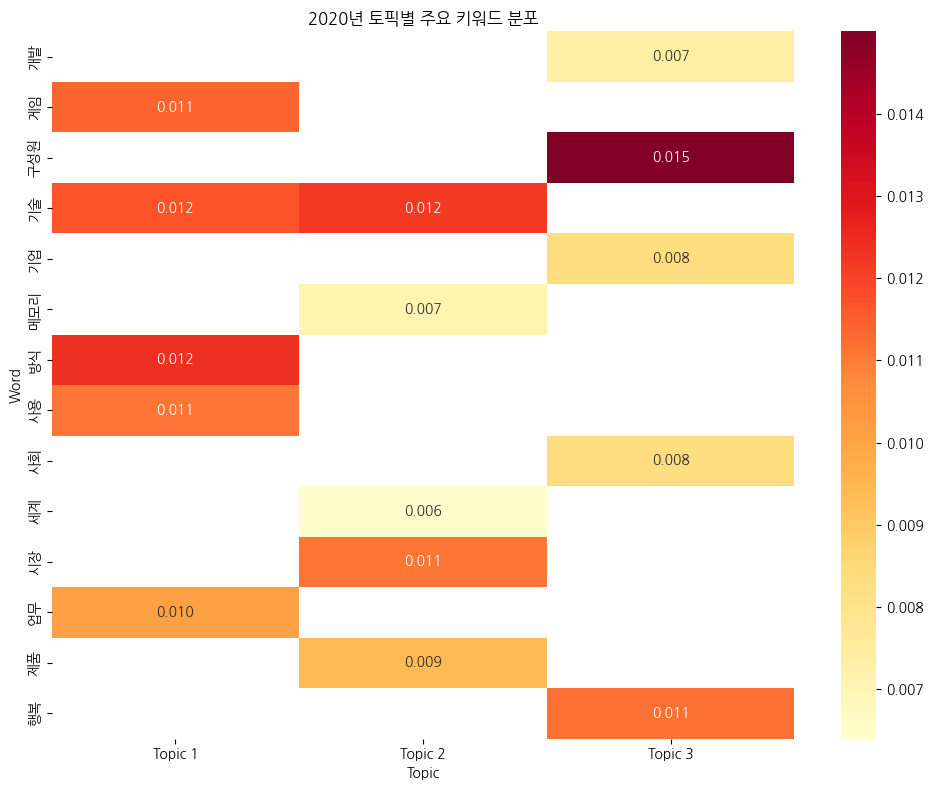

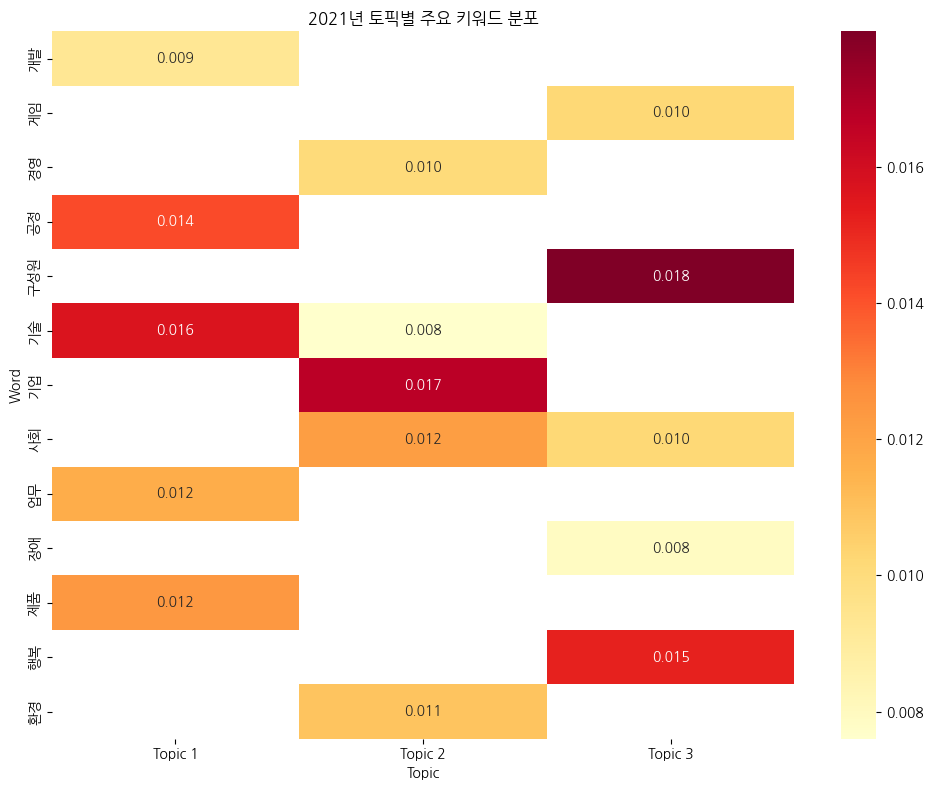

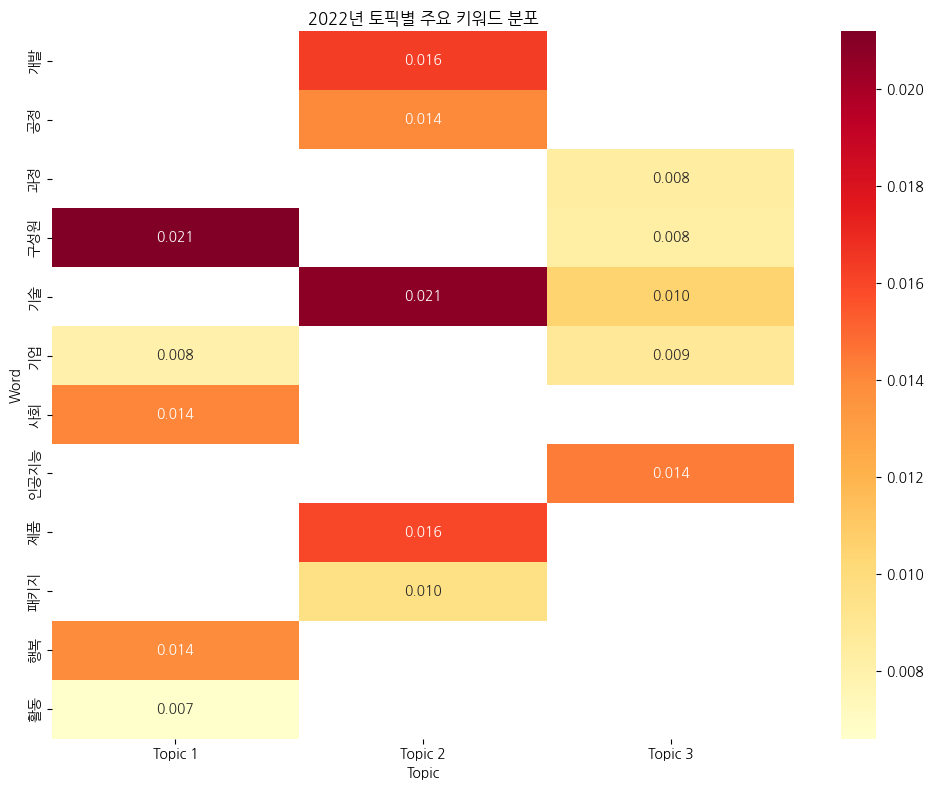

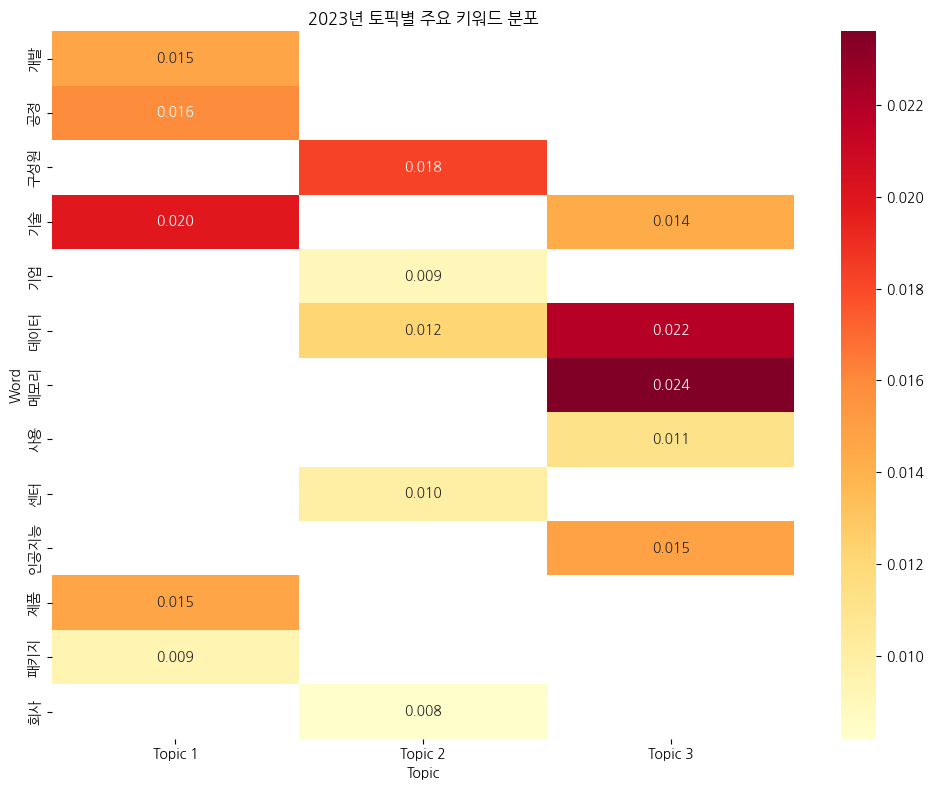

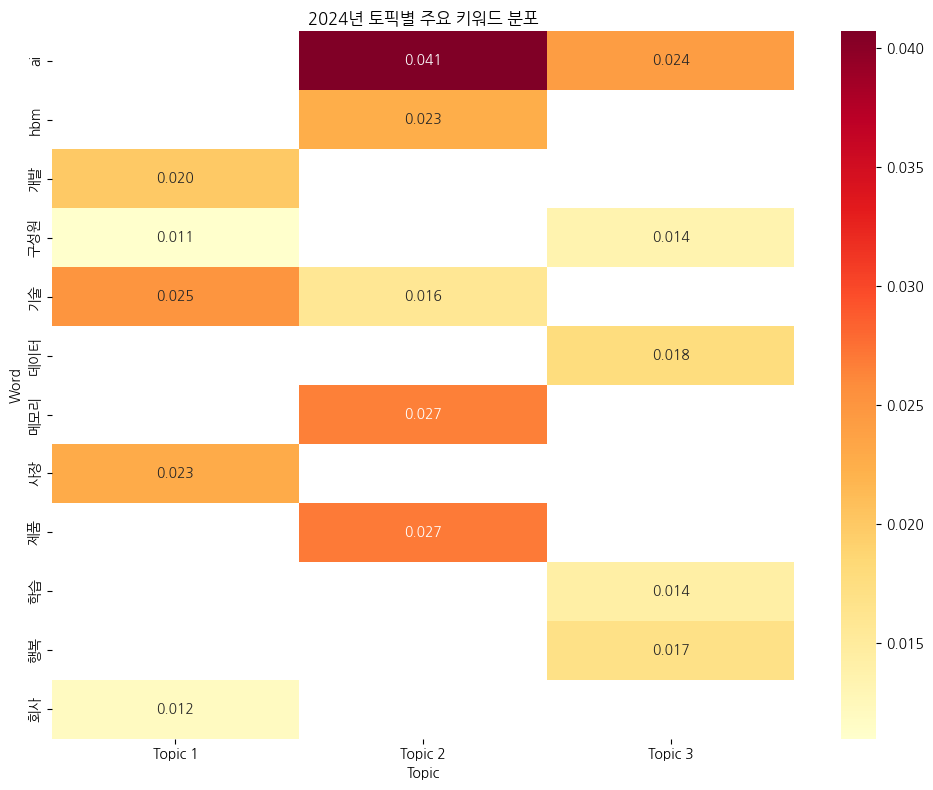

In [12]:
# 연도별 주요 토픽 키워드 히트맵 생성
import seaborn as sns

def create_topic_heatmap(yearly_topics, year):
    # 해당 연도의 토픽별 상위 키워드와 확률 추출
    topic_data = []
    for topic_idx, topic_words in yearly_topics[year].items():
        for word, prob in topic_words[:5]:  # 상위 5개 키워드만 사용
            topic_data.append({
                'Topic': f'Topic {topic_idx+1}',
                'Word': word,
                'Probability': prob
            })
    
    # 데이터프레임 생성
    df_heatmap = pd.DataFrame(topic_data)
    pivot_table = df_heatmap.pivot(index='Word', columns='Topic', values='Probability')
    
    # 히트맵 생성
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title(f'{year}년 토픽별 주요 키워드 분포')
    plt.tight_layout()
    plt.show()

# 각 연도별로 히트맵 생성
for year in sorted(yearly_topics.keys()):
    create_topic_heatmap(yearly_topics, year)

시각화화

<Figure size 1500x800 with 0 Axes>

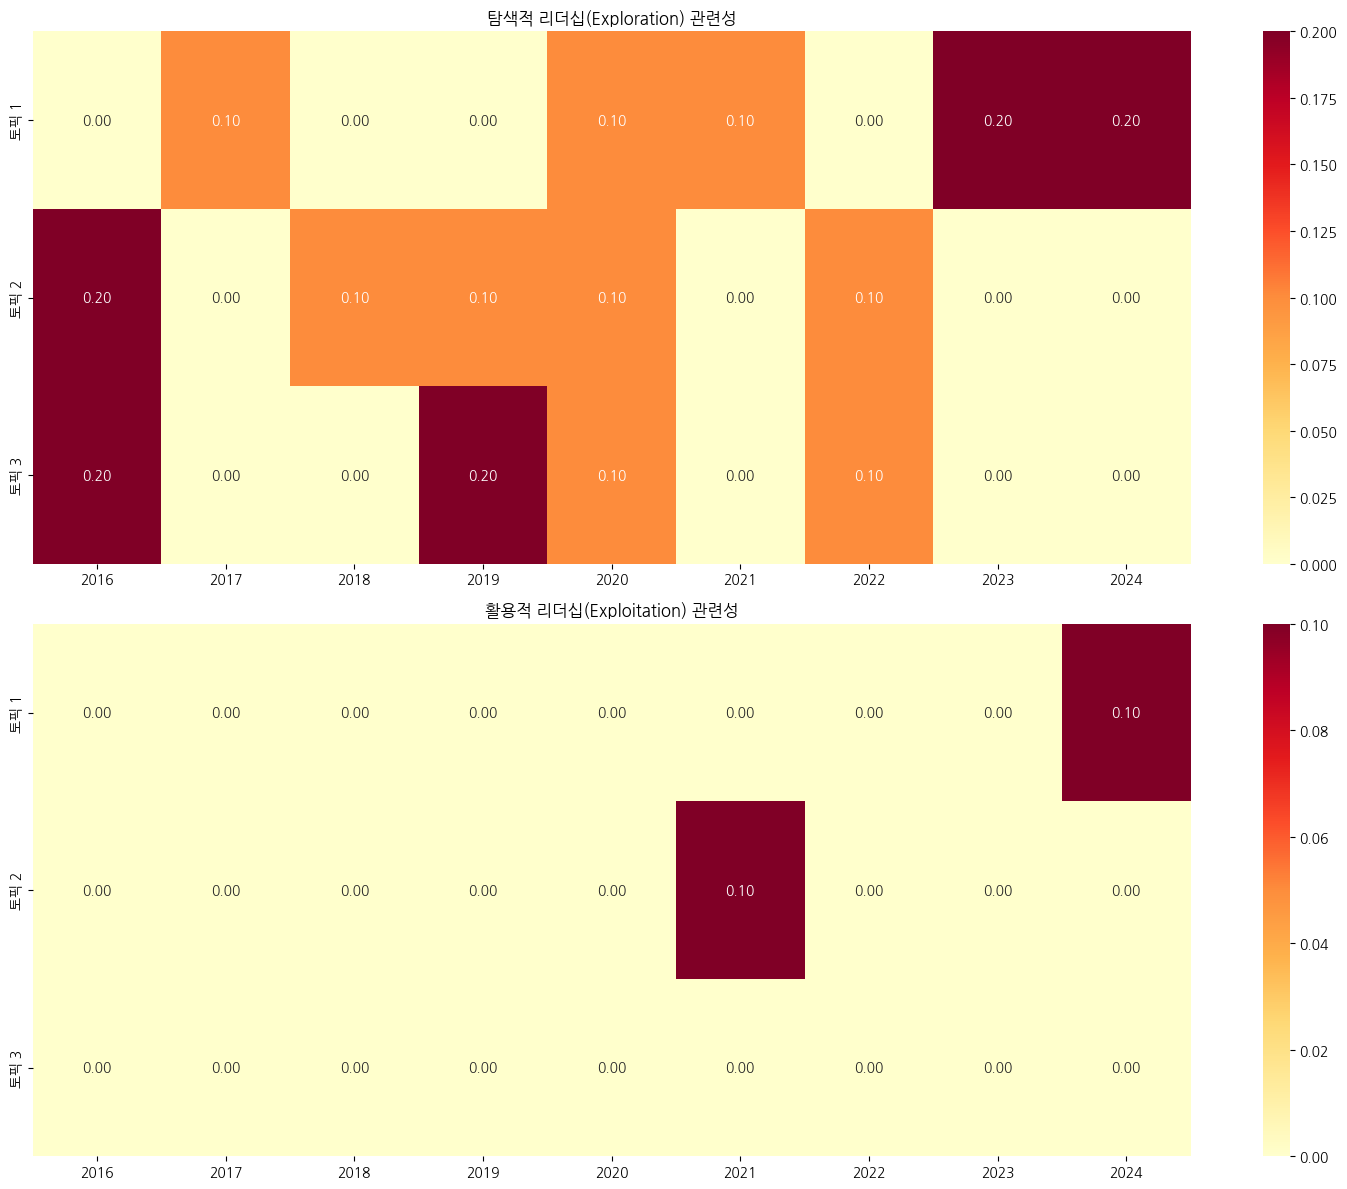

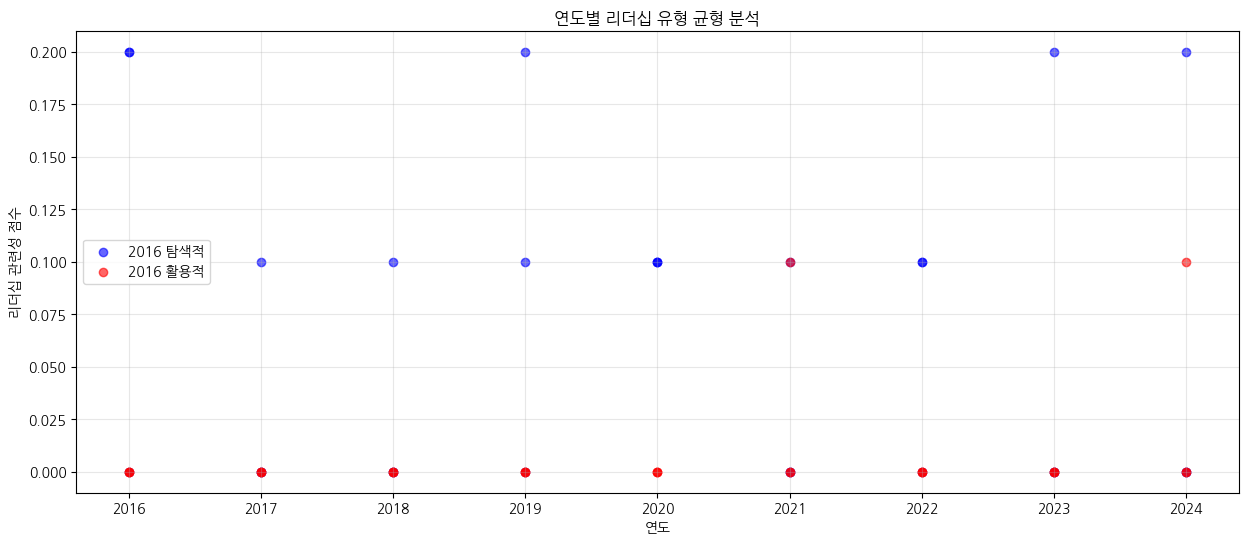


2016년 분석 결과:

토픽 1:
탐색적 리더십 관련성: 0.000
관련 키워드: 
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 2:
탐색적 리더십 관련성: 0.200
관련 키워드: 연구, 개발
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 3:
탐색적 리더십 관련성: 0.200
관련 키워드: 연구, 개발
활용적 리더십 관련성: 0.000
관련 키워드: 

2017년 분석 결과:

토픽 1:
탐색적 리더십 관련성: 0.100
관련 키워드: 개발
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 2:
탐색적 리더십 관련성: 0.000
관련 키워드: 
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 3:
탐색적 리더십 관련성: 0.000
관련 키워드: 
활용적 리더십 관련성: 0.000
관련 키워드: 

2018년 분석 결과:

토픽 1:
탐색적 리더십 관련성: 0.000
관련 키워드: 
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 2:
탐색적 리더십 관련성: 0.100
관련 키워드: 개발
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 3:
탐색적 리더십 관련성: 0.000
관련 키워드: 
활용적 리더십 관련성: 0.000
관련 키워드: 

2019년 분석 결과:

토픽 1:
탐색적 리더십 관련성: 0.000
관련 키워드: 
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 2:
탐색적 리더십 관련성: 0.100
관련 키워드: 개발
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 3:
탐색적 리더십 관련성: 0.200
관련 키워드: 연구, 개발
활용적 리더십 관련성: 0.000
관련 키워드: 

2020년 분석 결과:

토픽 1:
탐색적 리더십 관련성: 0.100
관련 키워드: 개발
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 2:
탐색적 리더십 관련성: 0.100
관련 키워드: 개발
활용적 리더십 관련성: 0.000
관련 키워드: 

토픽 3:
탐색적 리더십 관련성: 

In [15]:
def calculate_leadership_similarity(topic_words, leadership_keywords):
    """토픽과 리더십 유형 간의 유사도 계산"""
    topic_words_set = set(word.lower() for word, _ in topic_words)
    leadership_keywords_set = set(word.lower() for word in leadership_keywords)
    
    # 교집합의 크기를 기반으로 유사도 계산
    intersection = topic_words_set.intersection(leadership_keywords_set)
    similarity = len(intersection) / len(topic_words_set)
    
    return similarity, list(intersection)

# 연도별, 토픽별 리더십 유형 분석
leadership_analysis = {}

for year, topics in yearly_topics.items():
    leadership_analysis[year] = {}
    
    for topic_idx, topic_words in topics.items():
        # 각 리더십 유형과의 유사도 계산
        exploration_sim, exploration_words = calculate_leadership_similarity(
            topic_words, 
            domain_keywords['탐색적 리더십(Exploration)']
        )
        exploitation_sim, exploitation_words = calculate_leadership_similarity(
            topic_words, 
            domain_keywords['활용적 리더십(Exploitation)']
        )
        
        leadership_analysis[year][f'토픽 {topic_idx+1}'] = {
            '탐색적 리더십': exploration_sim,
            '활용적 리더십': exploitation_sim,
            '탐색적 키워드': exploration_words,
            '활용적 키워드': exploitation_words
        }

# 시각화 1: 히트맵으로 연도별 리더십 유형 분포 표시
plt.figure(figsize=(15, 8))

# 데이터 준비
years = sorted(leadership_analysis.keys())
topics = [f'토픽 {i+1}' for i in range(3)]
exploration_data = np.array([[leadership_analysis[year][topic]['탐색적 리더십'] 
                            for year in years] for topic in topics])
exploitation_data = np.array([[leadership_analysis[year][topic]['활용적 리더십'] 
                             for year in years] for topic in topics])

# 두 개의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# 탐색적 리더십 히트맵
sns.heatmap(exploration_data, 
            annot=True, 
            fmt='.2f', 
            cmap='YlOrRd',
            xticklabels=years,
            yticklabels=topics,
            ax=ax1)
ax1.set_title('탐색적 리더십(Exploration) 관련성')

# 활용적 리더십 히트맵
sns.heatmap(exploitation_data, 
            annot=True, 
            fmt='.2f', 
            cmap='YlOrRd',
            xticklabels=years,
            yticklabels=topics,
            ax=ax2)
ax2.set_title('활용적 리더십(Exploitation) 관련성')

plt.tight_layout()
plt.show()

# 시각화 2: 연도별 리더십 균형 분석
plt.figure(figsize=(15, 6))

for year in years:
    exploration_scores = [leadership_analysis[year][topic]['탐색적 리더십'] 
                         for topic in topics]
    exploitation_scores = [leadership_analysis[year][topic]['활용적 리더십'] 
                         for topic in topics]
    
    plt.scatter([year]*3, exploration_scores, 
                label=f'{year} 탐색적' if year == years[0] else "", 
                color='blue', alpha=0.6)
    plt.scatter([year]*3, exploitation_scores, 
                label=f'{year} 활용적' if year == years[0] else "", 
                color='red', alpha=0.6)

plt.title('연도별 리더십 유형 균형 분석')
plt.xlabel('연도')
plt.ylabel('리더십 관련성 점수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 분석 결과 출력
for year in years:
    print(f"\n{year}년 분석 결과:")
    for topic in topics:
        print(f"\n{topic}:")
        print(f"탐색적 리더십 관련성: {leadership_analysis[year][topic]['탐색적 리더십']:.3f}")
        print(f"관련 키워드: {', '.join(leadership_analysis[year][topic]['탐색적 키워드'])}")
        print(f"활용적 리더십 관련성: {leadership_analysis[year][topic]['활용적 리더십']:.3f}")
        print(f"관련 키워드: {', '.join(leadership_analysis[year][topic]['활용적 키워드'])}")

모든 연도별 이미지가 생성되었습니다.


<Figure size 2000x2500 with 0 Axes>

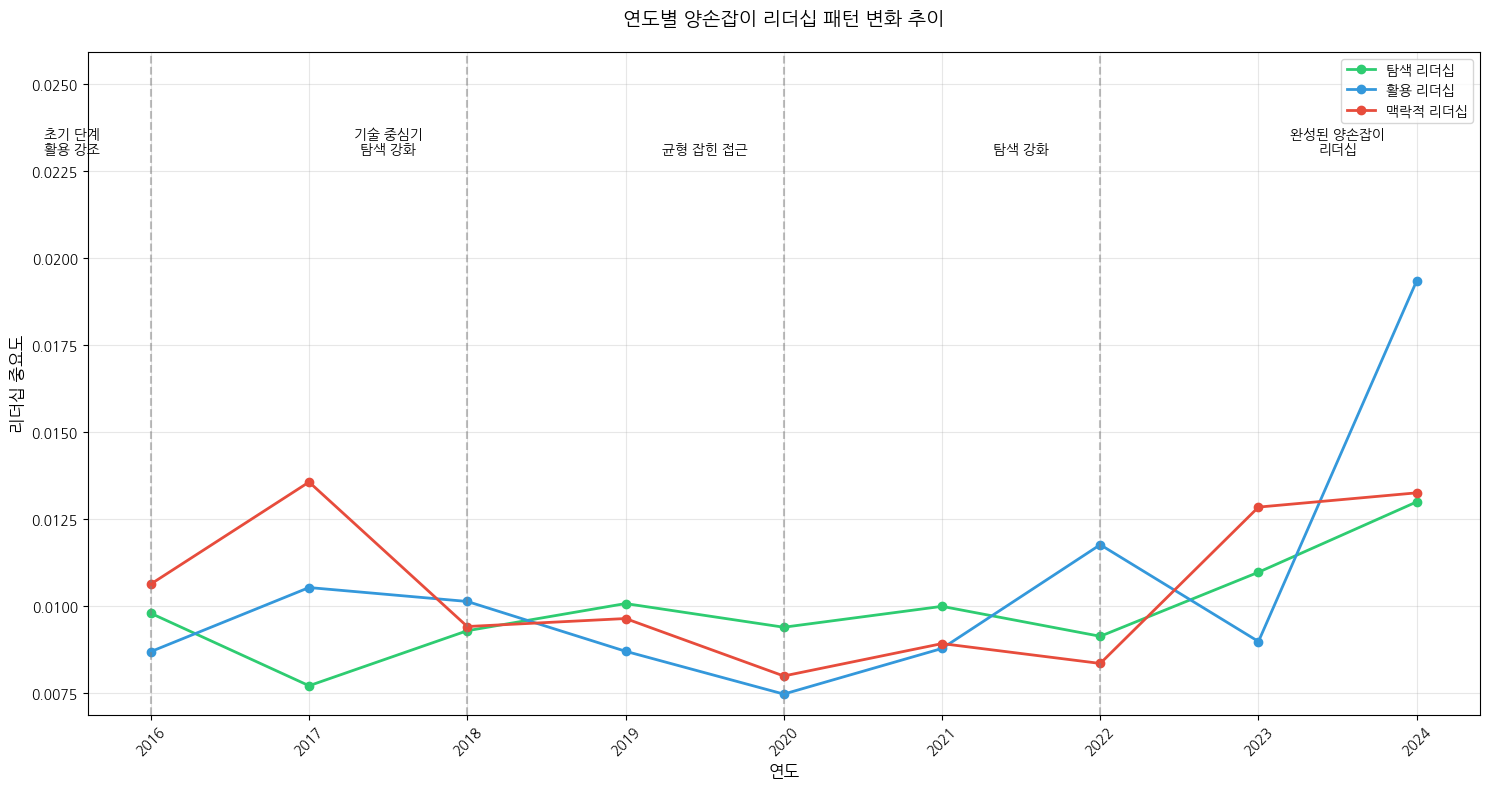


2016년 양손잡이 리더십 토픽 시각화 중 오류 발생: module 'pyLDAvis' has no attribute 'PyLDAVis'

2017년 양손잡이 리더십 토픽 시각화 중 오류 발생: module 'pyLDAvis' has no attribute 'PyLDAVis'

2018년 양손잡이 리더십 토픽 시각화 중 오류 발생: module 'pyLDAvis' has no attribute 'PyLDAVis'

2019년 양손잡이 리더십 토픽 시각화 중 오류 발생: module 'pyLDAvis' has no attribute 'PyLDAVis'

2020년 양손잡이 리더십 토픽 시각화 중 오류 발생: module 'pyLDAvis' has no attribute 'PyLDAVis'

2021년 양손잡이 리더십 토픽 시각화 중 오류 발생: module 'pyLDAvis' has no attribute 'PyLDAVis'

2022년 양손잡이 리더십 토픽 시각화 중 오류 발생: module 'pyLDAvis' has no attribute 'PyLDAVis'

2023년 양손잡이 리더십 토픽 시각화 중 오류 발생: module 'pyLDAvis' has no attribute 'PyLDAVis'

2024년 양손잡이 리더십 토픽 시각화 중 오류 발생: module 'pyLDAvis' has no attribute 'PyLDAVis'


In [16]:
# 연도별 양손잡이 리더십 패턴 시각화 (개별 차트)
years = sorted(yearly_topics.keys())
n_years = len(years)
n_cols = 2  # 한 행에 2개의 차트
n_rows = (n_years + 1) // 2  # 필요한 행 수 계산

# 전체 figure 크기 설정
fig = plt.figure(figsize=(20, 5*n_rows))

# 양손잡이 리더십 카테고리별 색상 정의
colors = {
    '탐색': '#2ecc71',  #  Exploration - 녹색
    '활용': '#3498db',  # Exploitation - 파란색
    '맥락적': '#e74c3c'     #  Contextual - 빨간색
}

# 토픽을 양손잡이 리더십 카테고리로 매핑
topic_mapping = {
    0: '탐색',    # 토픽 1: 탐색 Exploration
    1: '활용',   # 토픽 2: 활용 Exploitation
    2: '맥락적'      # 토픽 3: 맥락적 Contextual
}

# 연도별로 개별 이미지 생성
for year in years:
    # 각 연도별로 새로운 figure 생성
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    
    # 토픽별 데이터 준비
    for topic_idx, topic_words in yearly_topics[year].items():
        words, weights = zip(*topic_words[:7])  # 상위 7개 단어
        x_pos = np.arange(len(words))
        width = 0.25  # 막대 너비
        
        # 양손잡이 리더십 카테고리별 색상 적용
        category = topic_mapping[topic_idx]
        
        # 막대 그래프 그리기
        ax.bar(x_pos + (topic_idx * width), 
               weights, 
               width, 
               label=f'{category}',
               color=colors[category],
               alpha=0.7)
    
    # 그래프 꾸미기
    ax.set_title(f'{year}년 양손잡이 리더십 패턴', pad=20, fontsize=14)
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize=10)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('중요도', fontsize=12)
    
    # 연도별 특성 표시
    if year in [2015, 2016]:
        ax.text(0.5, 1.15, '초기 단계: 활용 강조', 
                transform=ax.transAxes, ha='center', fontsize=12)
    elif year in [2017, 2018]:
        ax.text(0.5, 1.15, '기술 중심기: 탐색 강화', 
                transform=ax.transAxes, ha='center', fontsize=12)
    elif year in [2019, 2020]:
        ax.text(0.5, 1.15, '균형 잡힌 접근', 
                transform=ax.transAxes, ha='center', fontsize=12)
    elif year in [2021, 2022]:
        ax.text(0.5, 1.15, '탐색 강화: AI/데이터 혁신', 
                transform=ax.transAxes, ha='center', fontsize=12)
    elif year in [2023, 2024, 2025]:
        ax.text(0.5, 1.15, '완성된 양손잡이 리더십', 
                transform=ax.transAxes, ha='center', fontsize=12)

    # 여백 조정
    plt.tight_layout()
    
    # 이미지 파일로 저장
    plt.savefig(f'leadership_pattern_{year}.png', 
                bbox_inches='tight',  # 여백 자동 조정
                dpi=300)             # 해상도 설정
    
    # 현재 figure 닫기 (메모리 관리)
    plt.close()

print("모든 연도별 이미지가 생성되었습니다.")

# 연도별 양손잡이 리더십 패턴 변화 추이 시각화
leadership_trends = pd.DataFrame()

for year in sorted(yearly_topics.keys()):
    year_leadership_weights = {}
    
    # 각 토픽의 주요 단어들의 평균 가중치 계산
    for topic_idx, topic_words in yearly_topics[year].items():
        category = topic_mapping[topic_idx]
        avg_weight = np.mean([weight for _, weight in topic_words])
        year_leadership_weights[category] = avg_weight
    
    leadership_trends = pd.concat([leadership_trends, 
                                 pd.DataFrame([year_leadership_weights], index=[year])])

# 연도별 양손잡이 리더십 패턴 변화 추이 시각화
plt.figure(figsize=(15, 8))  # 그래프 크기 증가

# 여백 설정
plt.subplots_adjust(top=0.85)  # 상단 여백 증가

for category in ['탐색', '활용', '맥락적']:
    plt.plot(leadership_trends.index, 
             leadership_trends[category], 
             marker='o', 
             color=colors[category], 
             linewidth=2,
             label=f'{category} 리더십')

plt.title('연도별 양손잡이 리더십 패턴 변화 추이', pad=20, fontsize=14)  # 제목 위치 조정
plt.xlabel('연도', fontsize=12)
plt.ylabel('리더십 중요도', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 주요 시기 구분선 추가
plt.axvline(x=2016, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=2018, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=2020, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=2022, color='gray', linestyle='--', alpha=0.5)

# y축 범위 설정하여 레이블 공간 확보
y_min, y_max = plt.ylim()
plt.ylim(y_min, y_max * 1.3)  # 상단 여백 30% 증가

# 시기별 레이블 추가 (위치 조정)
label_y_pos = y_max * 1.15  # 레이블 위치를 위로 이동
plt.text(2015.5, label_y_pos, '초기 단계\n활용 강조', ha='center', va='bottom', fontsize=10)
plt.text(2017.5, label_y_pos, '기술 중심기\n탐색 강화', ha='center', va='bottom', fontsize=10)
plt.text(2019.5, label_y_pos, '균형 잡힌 접근', ha='center', va='bottom', fontsize=10)
plt.text(2021.5, label_y_pos, '탐색 강화', ha='center', va='bottom', fontsize=10)
plt.text(2023.5, label_y_pos, '완성된 양손잡이\n리더십', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# pyLDAvis 시각화 (오류 수정)
for year, (lda_model, corpus, dictionary) in yearly_models.items():
    try:
        vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
        # topic_order 직접 수정 대신 새로운 방식으로 접근
        vis_data_dict = {
            'topic_coordinates': vis_data.topic_coordinates,
            'topic_info': vis_data.topic_info,
            'token_table': vis_data.token_table,
            'R': vis_data.R,
            'lambda_step': vis_data.lambda_step,
            'plot_opts': vis_data.plot_opts,
            'topic_order': list(range(lda_model.num_topics))  # 기본 토픽 순서 유지
        }
        
        # 수정된 시각화 저장
        pyLDAvis.save_html(pyLDAvis.PyLDAVis(**vis_data_dict), 
                          f'leadership_topic_visualization_{year}.html')
        print(f"\n{year}년 양손잡이 리더십 토픽 시각화가 성공적으로 저장되었습니다.")
    except Exception as e:
        print(f"\n{year}년 양손잡이 리더십 토픽 시각화 중 오류 발생: {str(e)}")